*Here, we build U-Net segmentation models to evaluate whether augmentation from the multi-modal VAE is useful (relative to not using any augmentation)*. 

see **ISPY2_VAE_multimodal.ipynb** for the multimodal VAE architecture. 

###1. [Set up the train, validation and test DataLoaders](#scrollTo=FslEjVrQhCCI&line=3&uniqifier=1)

###2. [Set up the U-Net architecture](#scrollTo=wD2BpRcRaqB2&line=10&uniqifier=1)

This is based on the [original paper](https://arxiv.org/abs/1505.04597), but we make a few modifications for our case. 

###3. [Train the U-Net on the original data](#scrollTo=CpJ2kscEjCxO&line=1&uniqifier=1)

###4. [Train the U-Net using augmentation](#scrollTo=5ruMHHfZYulL&line=1&uniqifier=1)

First, we [set up the saved multimodal VAE](#scrollTo=JysjfWdwUuIa&line=1&uniqifier=1). We will be using this to do augmentation. 

Next, we provide code to [augment each batch](h#scrollTo=A1p4VzT4i1Gn&line=11&uniqifier=1). Note that the realism of the generated images depends on the variance of the error we use (we chose to use a variance of 1/2). 

**on our chosen train/test/validation split of the data, we find no evidence to suggest that the augmentation is better; indeed, boht methods converge to the same validation loss of slightly below 0.4**

###5. [5-fold cross validation](#scrollTo=3-Jyvw3TiF4v&line=5&uniqifier=1)

We investigate if the results change with different partitions of the data. **Examining test fold loss, we find no consistent evidence to suggest that the augmentation is better.**

There could be several reasons: 

1. *How we use the augmentation*. Right now, we are mixing the augmented images with the actual ones. As we mentioned, the augmented images may not be as realisitc, so this may just be intriducing noise. A btter approach, might be to use the augmentation for pretraining the U-net, then complete training with the actual data later. 

2. *our sample size is quite large already*. we are working with approx 1500 images, which is by no means a small dataset. Augmentation tends to work better on extremely small datasets, so maybe here it's less useful. It would be interesting to subset to say, 30 patients, then rerun the whole procedure. It is reasonable then, that the augmented U-net would perform better. 


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 24 01:39:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
!pip install torchinfo
import pandas as pd
import seaborn as sns
torch.backends.cudnn.deterministic=True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle 

# with open('/content/drive/MyDrive/Colab Notebooks/t1_arraysstan_32.pkl', 'rb') as f: #minmax [-1,1]: t1_arraysmm_32
#     t1_arrays = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/t2_arraysstan_32.pkl', 'rb') as f:
#     t2_arrays = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/mask_arrayscropped_8.pkl', 'rb') as f:
#     mask_arrays = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/patient_labels.pkl', 'rb') as f:
#     patient_labels = pickle.load(f)

In [3]:
#download final output from Section 2 of ISPY_processing.ipynb
import gdown 

gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=18UiIIxQF8jtIZWYI3pkEaoAhZjDkLgmo","t1_arraysstan_32.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1--LgF7Ka9LiPvl6ANbDPHKpwO-4F__Y_","t2_arraysstan_32.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1-19CAZ8k1gWVaNCNbjbZfJz5ZJERFjx7","mask_arrayscropped_8.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1A8Ghp8bJExZenndd7P43t9GE0JuX41iC","patient_labels.pkl") #need patient labels for pytorch train/test split later

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=18UiIIxQF8jtIZWYI3pkEaoAhZjDkLgmo
To: /content/t1_arraysstan_32.pkl
100%|██████████| 981M/981M [00:05<00:00, 191MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1--LgF7Ka9LiPvl6ANbDPHKpwO-4F__Y_
To: /content/t2_arraysstan_32.pkl
100%|██████████| 981M/981M [00:04<00:00, 222MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-19CAZ8k1gWVaNCNbjbZfJz5ZJERFjx7
To: /content/mask_arrayscropped_8.pkl
100%|██████████| 245M/245M [00:00<00:00, 325MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1A8Ghp8bJExZenndd7P43t9GE0JuX41iC
To: /content/patient_labels.pkl
100%|██████████| 4.85k/4.85k [00:00<00:00, 5.13MB/s]


'patient_labels.pkl'

In [4]:
!ls 

drive			  patient_labels.pkl  t1_arraysstan_32.pkl
mask_arrayscropped_8.pkl  sample_data	      t2_arraysstan_32.pkl


In [5]:
import pickle

#load the files into namespace
with open('/content/t1_arraysstan_32.pkl', 'rb') as f: 
    t1_arrays = pickle.load(f)

with open('/content/t2_arraysstan_32.pkl', 'rb') as f: 
    t2_arrays = pickle.load(f)

with open('/content/mask_arrayscropped_8.pkl', 'rb') as f: 
    mask_arrays = pickle.load(f)

with open('/content/patient_labels.pkl', 'rb') as f:
    patient_labels = pickle.load(f)

### load original data

Our setting now with the U-Net is different from the VAE. There, we are not interested in comparing models, only finding out when to stop the training (i.e. stop  before overfitting on the validation set). 

But here, we look to compare the U-Net with/without augmentation. So, apart from the validation set for early stopping, we also set up a test set. 

In [6]:
train_prop = 0.6 #take 0.8 of patients for training

import random; random.seed(4) 
unique_p = list(dict.fromkeys(patient_labels)) #preserve order
train_p = random.sample(unique_p, 
                        int(train_prop*len(unique_p)))
print(len(train_p))

train_indexes = [e in train_p for e in patient_labels]
print("train prop:", sum(train_indexes)/len(train_indexes),
      "train size:", sum(train_indexes)) #0.8 of the data for training

61
train prop: 0.6085504342017368 train size: 911


In [7]:
def get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes, patient_labels):
  test_indexes = [not e for e in train_indexes]
  tv_p = np.array(patient_labels)[test_indexes] #testing and validation patients
  unique_tv_p = list(dict.fromkeys(tv_p)) #preserve order

  random.seed(4) 
  test_p = random.sample(unique_tv_p, 
                          int(0.5*len(unique_tv_p))) #take half for testing, half for validation

  valid_p = [p for p in unique_tv_p if p not in test_p]

  test_indexes = [e in test_p for e in patient_labels]; valid_indexes = [e in valid_p for e in patient_labels]

  return (t1_arrays[train_indexes], t2_arrays[train_indexes], mask_arrays[train_indexes],
         t1_arrays[valid_indexes], t2_arrays[valid_indexes], mask_arrays[valid_indexes],
         t1_arrays[test_indexes], t2_arrays[test_indexes], mask_arrays[test_indexes])


train_t1, train_t2, train_mask, valid_t1, valid_t2, valid_mask, test_t1, test_t2, test_mask = get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes, patient_labels)
print(train_t1.shape)
print(valid_t1.shape)
print(test_t1.shape)

(911, 320, 512)
(295, 320, 512)
(291, 320, 512)


In [8]:
from torch.utils.data import Dataset

class ISPY_dataset(Dataset):
  # DONT use t1 anymore. Redundant for training models here
  def __init__(self, t2_arrays, mask_arrays,
                     transforms):
    self.t2_arrays = t2_arrays
    self.mask_arrays = mask_arrays
    self.transforms = transforms

  def __len__(self):
    return self.t2_arrays.shape[0]

  def __getitem__(self, idx):
    t2 = t2_arrays[idx]; mask = mask_arrays[idx]

    ##transform the T1 and T2
    if self.transforms is not None: 
      t2 = self.transforms(t2)
      mask = self.transforms(mask)

    return (t2, mask)

In [9]:
# define transformations for T1 and T2
my_transforms = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize((128, 128))
  ])

train_data = ISPY_dataset(train_t2, train_mask, 
                          my_transforms)

test_data = ISPY_dataset( test_t2, test_mask, 
                          my_transforms)

valid_data = ISPY_dataset( valid_t2, valid_mask, 
                          my_transforms)

torch.set_printoptions(edgeitems=3)
print(train_data[0]) # t2 and mask
print(train_data[0][0].shape) #T2 has one channel, and is 128 x 128

(tensor([[[-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         ...,
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int8))
torch.Size([1, 128, 128])


In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 128, shuffle=True);
test_loader = DataLoader(test_data, batch_size = 128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size = 128, shuffle=True)

In [11]:
torch.manual_seed(3)
t2, mask = next(iter(train_loader))
print(t2.shape)

torch.Size([128, 1, 128, 128])


### U-Net Architecture

We use the original U-Net Architecture, see [this paper](https://arxiv.org/abs/1505.04597). I found [this blog post](https://amaarora.github.io/posts/2020-09-13-unet.html#u-net) really useful for implementing the original U-Net archiecture in Pytorch. 

We use some modifications:

- modify the architecture to work with our images of size 128x128
- apply padding to the convolutions so that borders are not cut off.  
- use batch normaliation after each convolutional layer
- our images are much smaller size than the 572x572 the original architecutre was designed around. Hence, we simplify the architecture (decrease the number of parameters), by using only three encoder blocks (instead of the origial five).

In [12]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1) #add padding = 1 so output has same shape?
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        return self.relu(self.bn2(self.conv2(
            self.relu(self.bn1(self.conv1(x)))
            )))

In [13]:
class Encoder(nn.Module):
  def __init__(self, chs=(1,16, 32, 64)):
        super().__init__()
        self.enc_blocks = nn.ModuleList( 
            [Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

  def forward(self, x):
        ftrs = [] #save the features to be passed over
        for block in self.enc_blocks:
          x = block(x) #tensors are immutable, the original datapoint is not affected, we just reassign x to point to block(x)
          ftrs.append(x)
          x = self.pool(x)
        
        return ftrs

In [14]:
from torchinfo import summary

summary(Encoder(), input_size= t2.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [128, 16, 128, 128]       --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Block: 2-1                        [128, 16, 128, 128]       --
│    │    └─Conv2d: 3-1                  [128, 16, 128, 128]       160
│    │    └─BatchNorm2d: 3-2             [128, 16, 128, 128]       32
│    │    └─ReLU: 3-3                    [128, 16, 128, 128]       --
│    │    └─Conv2d: 3-4                  [128, 16, 128, 128]       2,320
│    │    └─BatchNorm2d: 3-5             [128, 16, 128, 128]       32
│    │    └─ReLU: 3-6                    [128, 16, 128, 128]       --
├─MaxPool2d: 1-2                         [128, 16, 64, 64]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Block: 2-2                        [128, 32, 64, 64]         --
│    │    └─Conv2d: 3-7                  [128, 32, 64, 64]     

In [ ]:
#check 
# encoder = Encoder()
# x = torch.randn(t2.shape) 

# ftrs = encoder(x) #calls forward()
# for ftr in ftrs: print(ftr.shape)

In [16]:
#transposed convolutional layers for upsampling the feature map, while halving #channels

class Decoder(nn.Module):
    def __init__(self, chs=(64, 32, 16)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1],kernel_size = 3, stride = 2, padding = 1, output_padding = 1) for i in range(len(chs)-1)])#max pooling in Encoder had stride 2
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 

    def forward(self, x, encoder_features): #encoder_features = output from the encoder
        
        for i in range(len(self.chs)-1):
            #print(i)
            x        = self.upconvs[i](x) #use the ith upconv
            #print("x",x.shape)
            enc_ftrs = self.crop(encoder_features[i], x) #use the ith output from encoder (after reversing them, see below)
            #print("enc_ftrs",enc_ftrs.shape)
            x        = torch.cat([enc_ftrs, x], dim=1) #[x, enc_ftrs] in the code
            #print("x cat enc_ftrs", x.shape)
            x        = self.dec_blocks[i](x)
            #print("got here")
            #print("first block output:", x.shape,"\n")

        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs) # a (H,W) crop from the centre
        return enc_ftrs

In [ ]:
# decoder = Decoder()
# x = torch.randn(128, 64, 32, 32)
# decoder(x, ftrs[::-1][1:]).shape #skip the first element, since it's not used to concatenate

In [ ]:
# [ftr.shape for ftr in ftrs[::-1][1:]]

In [ ]:
#summary(Decoder(), input_size= (128, 32, 32, 32), encoder_features = ftrs[::-1][1:])

In [17]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(1,8,16,32,64), dec_chs=(64, 32, 16, 8), 
                 num_class=1, retain_dim=False, out_sz=(128,128)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, kernel_size = 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [ ]:
#check
# unet = UNet(retain_dim=False)
# x    = torch.randn(t2.shape)
# unet(x).shape

### train U-Net without augmentation

In [18]:
def dice_loss(input, target):
  #input and target are tensors
    smooth = 1.0

    iflat = input #iflat = input.view(-1)
    tflat = target#tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [19]:
def validate_one_epoch(autoencoder, loader):
  
    autoencoder.eval()# Set model to evaluation mode
    num_samples = len(loader.dataset) 
    bce_loss = nn.BCEWithLogitsLoss()
    dice = 0.0; bce = 0.0
    
    for i, (t2, mask) in enumerate(loader):

        t2 = t2.to(device);  mask = mask.to(device, dtype = torch.float)
        
        with torch.no_grad():  # sure that we will not backpropagate
              
            mask_hat = autoencoder(t2) #logits
            
            bce += bce_loss(mask_hat, mask)*(t2.shape[0]/num_samples)
            dice += dice_loss(torch.sigmoid(mask_hat), mask)*(t2.shape[0]/num_samples)        

    return dice, bce

#early stopper https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            print("validation didn't improve")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
#Note: this train() function doesn't do augmentation, like the one below. But the training results are the same if the train() below has augmentation set to 0. (Reproduced on same seed). 

def train(autoencoder, data, valid_data, epochs=3, lr = 0.003):
    early_stopper = EarlyStopper(patience=10, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(autoencoder.parameters(), lr) #default lr = 0.001
    bce_loss = nn.BCEWithLogitsLoss()
    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0; table['train dice'] = 0.0; table['train bce'] = 0.0
    table['valid loss'] = 0.0; table['valid dice'] = 0.0; table['valid bce'] = 0.0

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.00
      for i, (t2, mask) in enumerate(data):
            t2 = t2.to(device); mask = mask.to(device,dtype=torch.float)

            opt.zero_grad()

            mask_hat = autoencoder(t2) #logits
            
            bce =  bce_loss(mask_hat, mask)
            dice = dice_loss(torch.sigmoid(mask_hat), mask)
            loss = dice + bce
            
            print("batch {} loss {:.5} DICE: {:.5} BCE {:.5}".format(i, loss.item(), dice.item(), bce.item()))
  
            loss.backward()
            opt.step()

             # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t2.shape[0]/num_samples)

      valid_dice, valid_bce = validate_one_epoch(autoencoder, valid_data)
      print("validation loss {:.5} DICE {:.4} BCE {:.4}\n".format(valid_dice + valid_bce, valid_dice, valid_bce))

      table.iloc[epoch, 1] = np.round(train_loss, 3); 
      table.iloc[epoch, 2] = np.round(dice.item(), 3); 
      table.iloc[epoch, 3] = np.round(bce.item(), 3)
      table.iloc[epoch, 4] = np.round((valid_dice + valid_bce).item(), 3); table.iloc[epoch, 5] = np.round((valid_dice).item(), 3); table.iloc[epoch, 6] = np.round((valid_bce).item(), 3)

      if early_stopper.early_stop(valid_dice + valid_bce ):     
        break
            
    return unet, table

torch.manual_seed(5) 
unet = UNet(retain_dim=False).to(device)
unet, table = train(unet, train_loader, valid_loader, epochs = 150, lr = 0.003)

epoch: 0
batch 0 loss 1.6912 DICE: 0.99391 BCE 0.69731
batch 1 loss 1.6545 DICE: 0.99706 BCE 0.65744
batch 2 loss 1.6357 DICE: 0.99735 BCE 0.63837
batch 3 loss 1.6182 DICE: 0.99707 BCE 0.62115
batch 4 loss 1.6004 DICE: 0.99608 BCE 0.60432
batch 5 loss 1.5852 DICE: 0.99678 BCE 0.58839
batch 6 loss 1.571 DICE: 0.99555 BCE 0.57541
batch 7 loss 1.56 DICE: 0.99826 BCE 0.56179
validation loss 1.5735 DICE 0.9959 BCE 0.5775

epoch: 1
batch 0 loss 1.5742 DICE: 0.99714 BCE 0.57711
batch 1 loss 1.5617 DICE: 0.99636 BCE 0.56539
batch 2 loss 1.5487 DICE: 0.99775 BCE 0.55092
batch 3 loss 1.53 DICE: 0.99734 BCE 0.53263
batch 4 loss 1.509 DICE: 0.99775 BCE 0.5113
batch 5 loss 1.4828 DICE: 0.99846 BCE 0.48433
batch 6 loss 1.4534 DICE: 0.99917 BCE 0.45423
batch 7 loss 1.4202 DICE: 0.99962 BCE 0.42056
validation loss 1.3798 DICE 0.9998 BCE 0.38

epoch: 2
batch 0 loss 1.3812 DICE: 0.99976 BCE 0.38141
batch 1 loss 1.3122 DICE: 0.99989 BCE 0.31233
batch 2 loss 1.1494 DICE: 0.99991 BCE 0.14951
batch 3 loss 1

### results

In [ ]:
table = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mri_models/ori_unet_seed5_lr_003.csv")
table = table[table['train loss'] != 0.0]

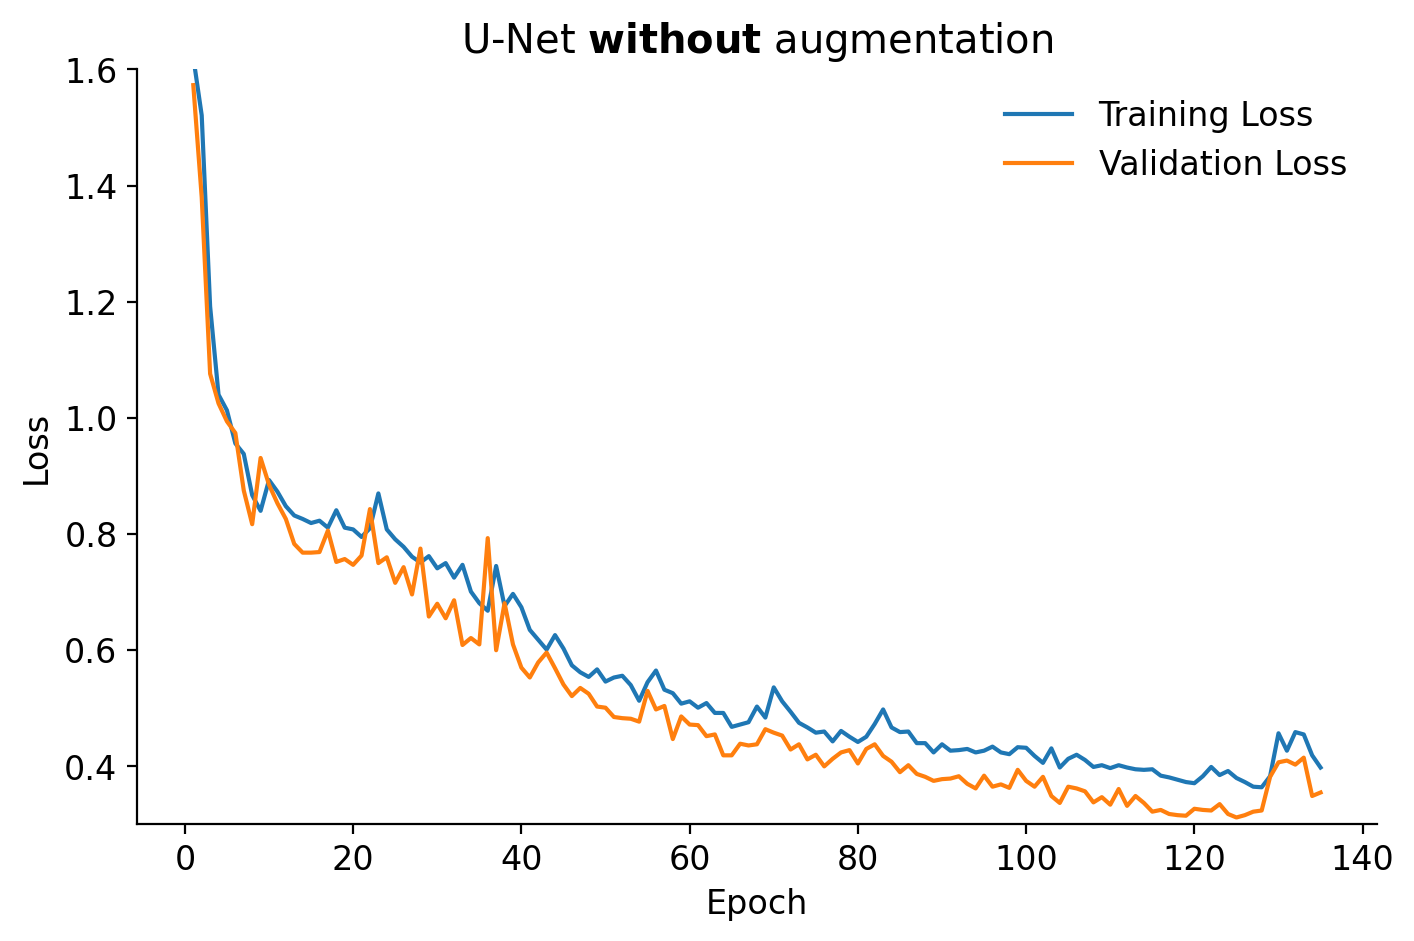

In [ ]:
#lr 0.005, patience 10 

#Q: why is validation loss less than training?

#Q: compare convergence against augmented ver
plt.rcParams.update({'font.size': 12})

fig , axes = plt.subplots(1, 1, figsize=(8, 5))
axes.set_ylim([0.3, 1.6])
axes.plot(table['epoch'], table['train loss'], label = 'Training Loss')
axes.plot(table['epoch'], table['valid loss'], label = 'Validation Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend(fontsize=12, frameon=False, prop={'size': 12})
plt.title(r"U-Net $\bf{without}$ augmentation")
sns.despine()

# plt.savefig("/content/drive/MyDrive/Colab Notebooks/mri_models/Fig_ori.png", 
#                bbox_inches='tight', dpi = 200, facecolor="white")

plt.show()



In [ ]:
#test set DICE
dice = 0.0; bce = 0.0

num_samples = len(test_loader.dataset); bce_loss = nn.BCEWithLogitsLoss()
for i, (t2, mask) in enumerate(test_loader):
    t2 = t2.to(device);  mask = mask.to(device, dtype = torch.float)
        
    with torch.no_grad():  # sure that we will not backpropagate
              
        mask_hat = unet(t2) #logits
            
        bce += bce_loss(mask_hat, mask)*(t2.shape[0]/num_samples)
        dice += dice_loss(torch.sigmoid(mask_hat), mask)*(t2.shape[0]/num_samples)

print("test bce {}, test dice {}".format(bce, dice))

test bce 0.009587248787283897, test dice 0.34475308656692505


In [ ]:
torch.manual_seed(5)
(t2_vis, mask_vis)= next(iter(test_loader)) #get one batch for visualisation
t2_vis = t2_vis.to(device); mask_vis = mask_vis.to(device, dtype = torch.float)
reconstructions = unet(t2_vis)

In [ ]:
def show_subplot(t2, mask, maskh):
    plt.rcParams.update({'font.size': 7})
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 3, 1); plt.title("T2"); plt.axis("off")
    plt.imshow(t2)
    
    plt.subplot(1, 3, 2); plt.title("Mask"); plt.axis("off")
    plt.imshow(mask)

    plt.subplot(1, 3, 3); plt.title("Predicted mask"); plt.axis("off")
    plt.imshow(maskh, vmin = torch.min(mask), vmax = torch.max(mask)) 

    plt.show()

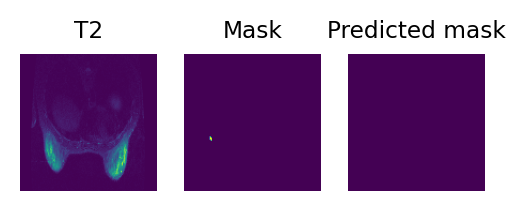

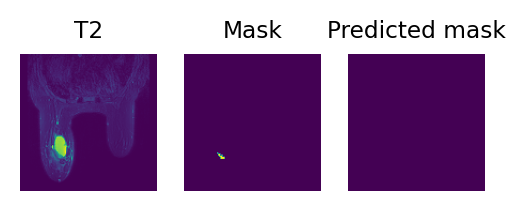

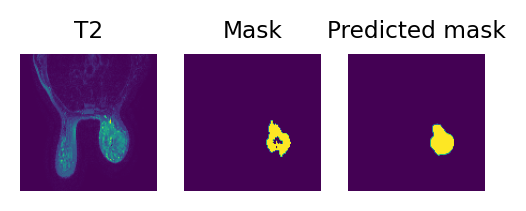

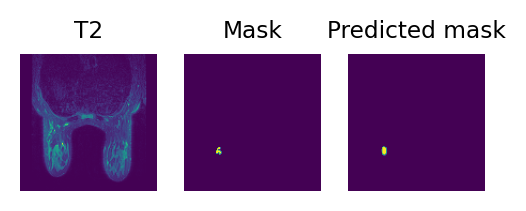

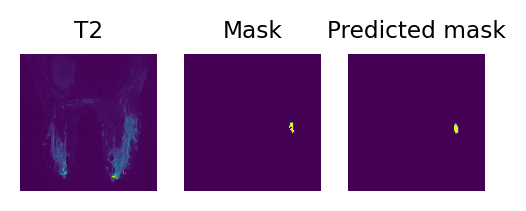

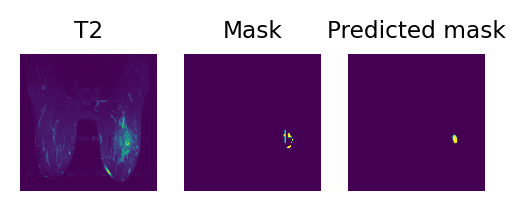

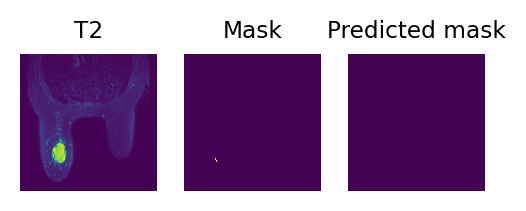

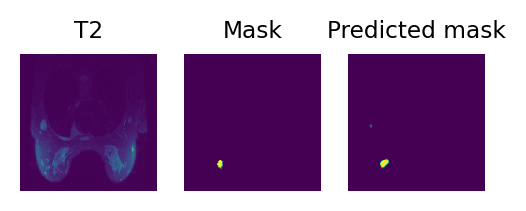

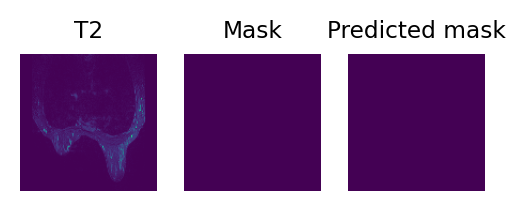

In [ ]:
#BCE and dice
idx = [1,4,8,9,15, 17, 25, 27, 28]

t2s = [t2_vis[id][0] for id in idx]
masks = [mask_vis[id][0] for id in idx]

maskhs = [reconstructions[id][0] for id in idx]

for i in range(len(idx)):
  show_subplot(t2s[i].cpu(), masks[i].cpu(), torch.sigmoid(maskhs[i]).cpu().detach())

## save models

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/mri_models' + "/unet_ori_003.pth"
print(path)

# Save parameters
#torch.save(unet.state_dict(), path)

/content/drive/MyDrive/Colab Notebooks/mri_models/unet_ori_003.pth


In [ ]:
#table.to_csv("/content/drive/MyDrive/Colab Notebooks/mri_models/ori_unet_seed5_lr_003.csv", index = False)

In [ ]:
# Instantiate model
ori_unet = UNet(retain_dim=False).to(device)

# Load saved parameters
ori_unet.load_state_dict(torch.load(path))
ori_unet.eval()

In [ ]:
test_recons = torch.sigmoid(ori_unet(t2_vis));

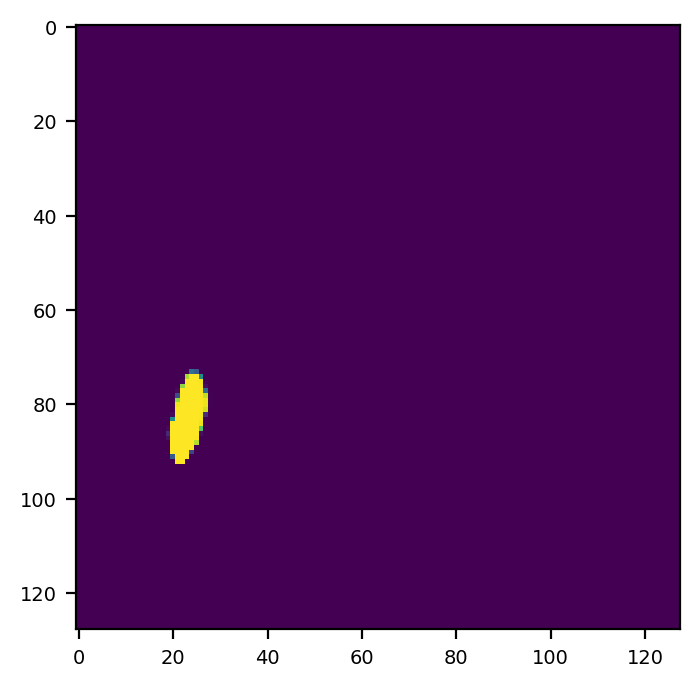

In [ ]:
plt.imshow(test_recons[0][0].cpu().detach().numpy())

## U-Net using augmented (T2, Mask) pairs

### set up multimodal VAE

Set up the saved VAE we will be using to augment our batches. 

In [20]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(2, 8, kernel_size = 3, stride = 2, padding = 1) #increase the number of channels
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(16)

        #mean and stds
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x))); x = self.pool(x)

        x = F.leaky_relu(self.bn2(self.conv2(x))); x = self.pool(x)

        mu =  self.conv3(x)
        sigma = torch.exp(self.conv4(x)) #exponential activation to ensure positive
        z = mu + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2)
        return z

In [21]:
class T2_Decoder(nn.Module):
    def __init__(self):
        super(T2_Decoder, self).__init__()
        self.convt1 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.convt2 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
        self.bn2 = nn.BatchNorm2d(8)

        self.convt3 = nn.ConvTranspose2d(8, 1, kernel_size = 5,  stride = 4, padding = 1, output_padding = 1) #undo the maxpool and conv
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self, z):
        z = F.leaky_relu(self.bn1(self.convt1(z)))

        z = F.leaky_relu(self.bn2(self.convt2(z)))
        
        z = self.bn3(self.convt3(z))
        
        x = z 
        #new idea: drop the activation entirely! https://qr.ae/pr5s0Y
        return x

class Mask_Decoder(nn.Module):
    def __init__(self):
        super(Mask_Decoder, self).__init__()
        self.convt1 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.convt2 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
        self.bn2 = nn.BatchNorm2d(8)

        self.convt3 = nn.ConvTranspose2d(8, 1, kernel_size = 5,  stride = 4, padding = 1, output_padding = 1) #undo the maxpool and conv
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self, z):
        z = F.leaky_relu(self.bn1(self.convt1(z)))

        z = F.leaky_relu(self.bn2(self.convt2(z)))
        
        logits = self.convt3(z)
        p = torch.sigmoid(logits) #for when DICE
        return p

In [22]:
#change out the Encoder for Variational Encoder
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.t2_decoder = T2_Decoder()
        self.mask_decoder = Mask_Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return torch.cat([self.t2_decoder(z), self.mask_decoder(z)], dim = 1)

In [23]:
# Create a folder called mri_models if there isn't one
import os

path = '/content/drive/MyDrive/Colab Notebooks/mri_models' + "/T2_Mask_VAE.pth"

In [24]:
# Instantiate model
vae = VariationalAutoencoder().to(device) 

# Load saved parameters
vae.load_state_dict(torch.load(path))
vae.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (t2_decoder): T2_Decoder(
    (convt1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convt2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1), output_padding=(1, 1))
    (bn2): Batch

## Augment each batch

For a given batch of images,

1. Use the encoder to get their corresponding points in latent space

2. Perturb the points using some error, e.g. $\epsilon \sim N(0,1)$

3. Use the decoder to reconstruct the perturbed points

see **ISPY_VAE.ipynb**

In [28]:
def generate_from_batch(t2_mask, vae, prop = 0.25):
  #given t2_mask: tensor, feeds the batch through encoder -> get corresponding points in latent space
  #prop: what prop of the batch to augment? 
  assert t2_mask.shape[1] == 2 # VAE needs 2 channels 
  batch_size = t2_mask.shape[0]
  
  latent_points = vae.encoder(torch.index_select(t2_mask, 0, torch.tensor(list(range(int(batch_size*prop)))).to(device)))
  
  epsilons = torch.distributions.Normal(0, 1/2).sample(latent_points.shape).to(device) #sample errors. same size

  new_latent_points = torch.add(latent_points, epsilons)#perturb the points

  #decode the perturbed points. Voila!
  new_t2 = vae.t2_decoder(new_latent_points)
  new_masks = vae.mask_decoder(new_latent_points)
  
  return new_t2, new_masks

In [26]:
def show_subplot(t2, mask, t2h, maskh):
    plt.rcParams.update({'font.size': 7})
    plt.figure(figsize=(4, 4))
    plt.subplot(1, 4, 1); plt.title("T2"); plt.axis("off")
    plt.imshow(t2)
    
    plt.subplot(1, 4, 2); plt.title("Mask"); plt.axis("off")
    plt.imshow(mask)

    plt.subplot(1, 4, 3); plt.title("New T2"); plt.axis("off")
    plt.imshow(t2h, vmin = t2.min(), vmax = t2.max()) #, vmin = torch.min(mask), vmax = torch.max(mask)

    plt.subplot(1, 4, 4); plt.title("New Mask"); plt.axis("off")
    plt.imshow(maskh)

    plt.show()

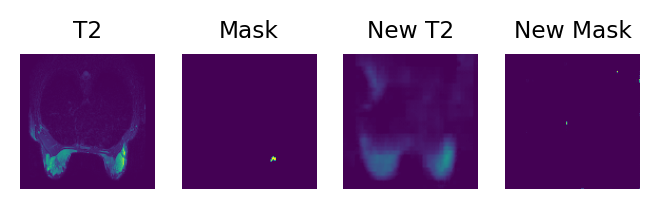

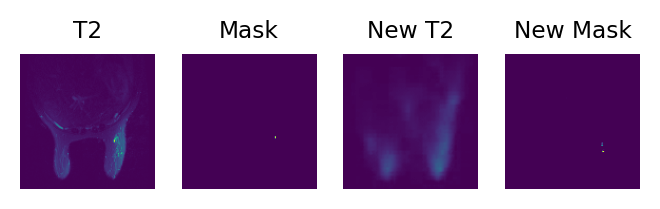

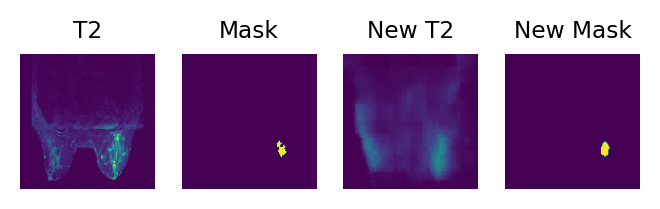

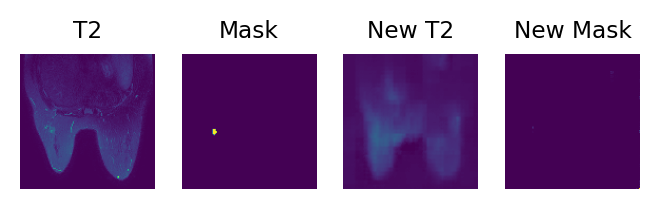

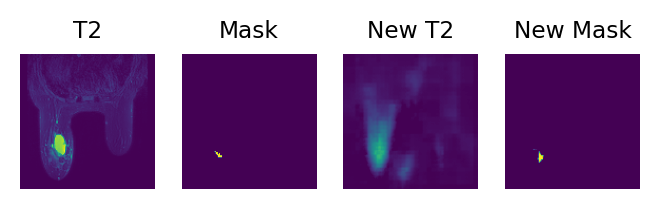

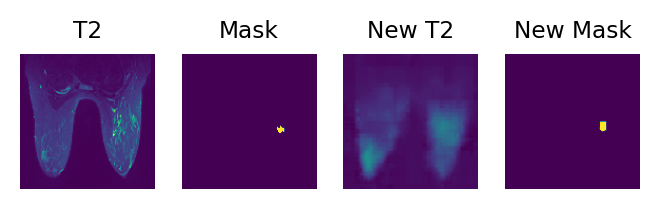

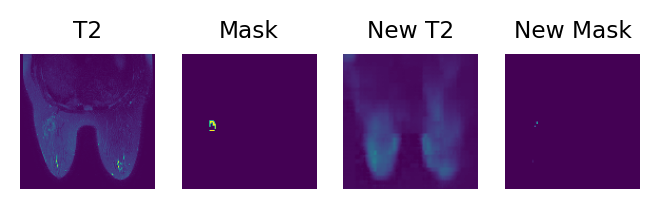

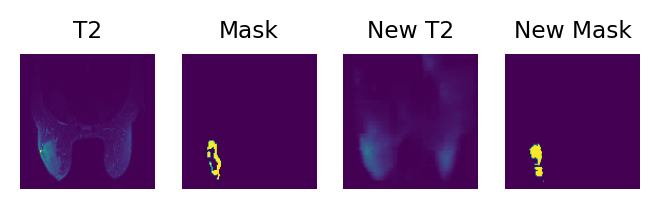

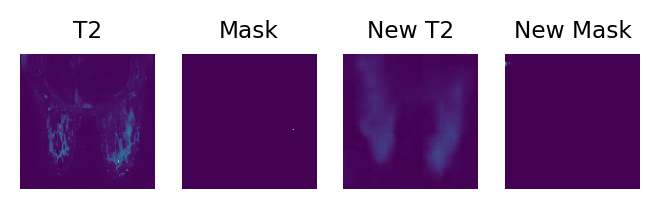

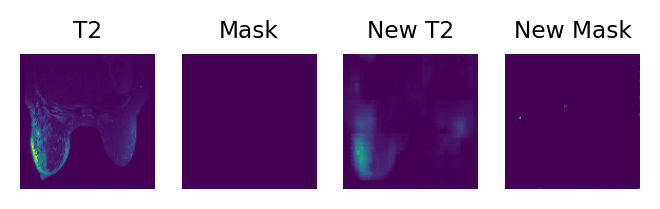

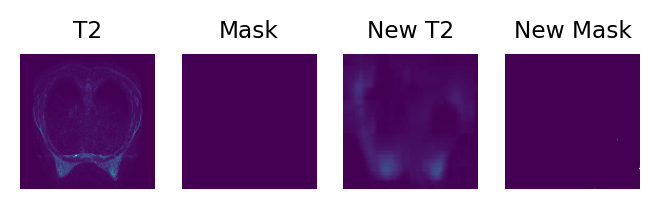

In [29]:
#Visualise the augmentation
torch.manual_seed(9) 
for i, (t2, mask) in enumerate(train_loader):
    t2 = t2.to(device); mask = mask.to(device,dtype=torch.float)

    t2_mask = torch.cat([t2, mask], dim = 1)

    new_t2, new_masks = generate_from_batch(t2_mask, vae = vae)

    if i == 0:

      for j in range(11):
         show_subplot(t2[j][0].cpu().detach(), 
                      mask[j][0].cpu().detach(), 
                      new_t2[j][0].cpu().detach(), 
                      new_masks[j][0].cpu().detach())
    

### train 

In [ ]:
def train(model, data, valid_data, epochs=3, lr = 0.003, augment_batch = False, prop = 0.25):
    early_stopper = EarlyStopper(patience=10, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(model.parameters(), lr) #default lr = 0.001
    bce_loss = nn.BCEWithLogitsLoss()
    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0; table['train dice'] = 0.0; table['train bce'] = 0.0
    table['valid loss'] = 0.0; table['valid dice'] = 0.0; table['valid bce'] = 0.0

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.0

      for i, (t2, mask) in enumerate(data):
            t2 = t2.to(device); mask = mask.to(device,dtype=torch.float)
            
            if augment_batch and prop > 0:
              new_t2, new_masks = generate_from_batch(torch.cat([t2, mask], dim = 1), vae, prop = prop)
              t2 = torch.cat([t2, new_t2],dim = 0); mask = torch.cat([mask, new_masks], dim = 0)
            
            opt.zero_grad()

            mask_hat = model(t2) #logits
            bce =  bce_loss(mask_hat, mask)
            dice = dice_loss(torch.sigmoid(mask_hat), mask)
            loss = dice + bce
            
            #print("batch {} size {} loss {:.5} DICE: {:.5} BCE {:.5}".format(i, t2.shape[0], loss.item(), dice.item(), bce.item()))
  
            loss.backward()
            opt.step()

             # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t2.shape[0]/num_samples)

      print("train loss {:.5} DICE {:.4} BCE {:.4}".format(train_loss, dice.item(), bce.item()))
      valid_dice, valid_bce = validate_one_epoch(model, valid_data)
      print("validation loss {:.5} DICE {:.4} BCE {:.4}\n".format(valid_dice + valid_bce, valid_dice, valid_bce))

      table.iloc[epoch, 1] = np.round(train_loss, 3); 
      table.iloc[epoch, 2] = np.round(dice.item(), 3); 
      table.iloc[epoch, 3] = np.round(bce.item(), 3)
      table.iloc[epoch, 4] = np.round((valid_dice + valid_bce).item(), 3); table.iloc[epoch, 5] = np.round((valid_dice).item(), 3); table.iloc[epoch, 6] = np.round((valid_bce).item(), 3)

      if early_stopper.early_stop(valid_dice + valid_bce):             
        break
            
    return unet, table

In [ ]:
torch.manual_seed(5) 
unet = UNet(retain_dim=False).to(device)
unet, table = train(unet, train_loader, valid_loader, epochs = 150, lr = 0.003, augment_batch = True, prop = 0.2)

epoch: 0
train loss 1.935 DICE 0.9985 BCE 0.5559
validation loss 1.5737 DICE 0.9959 BCE 0.5778

epoch: 1
train loss 1.824 DICE 0.9997 BCE 0.4228
validation loss 1.3861 DICE 0.9996 BCE 0.3865

epoch: 2
train loss 1.4483 DICE 0.9999 BCE 0.04905
validation loss 1.0649 DICE 1.0 BCE 0.0649

epoch: 3
train loss 1.2396 DICE 0.9985 BCE 0.02729
validation loss 1.022 DICE 0.9989 BCE 0.02311

epoch: 4
train loss 1.2082 DICE 0.946 BCE 0.009696
validation loss 0.97215 DICE 0.9575 BCE 0.01463

epoch: 5
train loss 1.1338 DICE 0.8496 BCE 0.007485
validation loss 0.88702 DICE 0.8739 BCE 0.01316

epoch: 6
train loss 1.081 DICE 0.9048 BCE 0.01713
validation loss 0.88259 DICE 0.863 BCE 0.01958

epoch: 7
train loss 1.0572 DICE 0.8122 BCE 0.0168
validation loss 0.82105 DICE 0.8035 BCE 0.01751

epoch: 8
train loss 1.0145 DICE 0.8267 BCE 0.04831
validation loss 0.82036 DICE 0.7923 BCE 0.02811

epoch: 9
train loss 1.049 DICE 0.8147 BCE 0.03473
validation loss 0.79775 DICE 0.7747 BCE 0.02301

epoch: 10
train lo

In [ ]:
table = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mri_models/aug_unet_seed5_lr_003.csv")
table = table[table['train loss'] != 0.0]

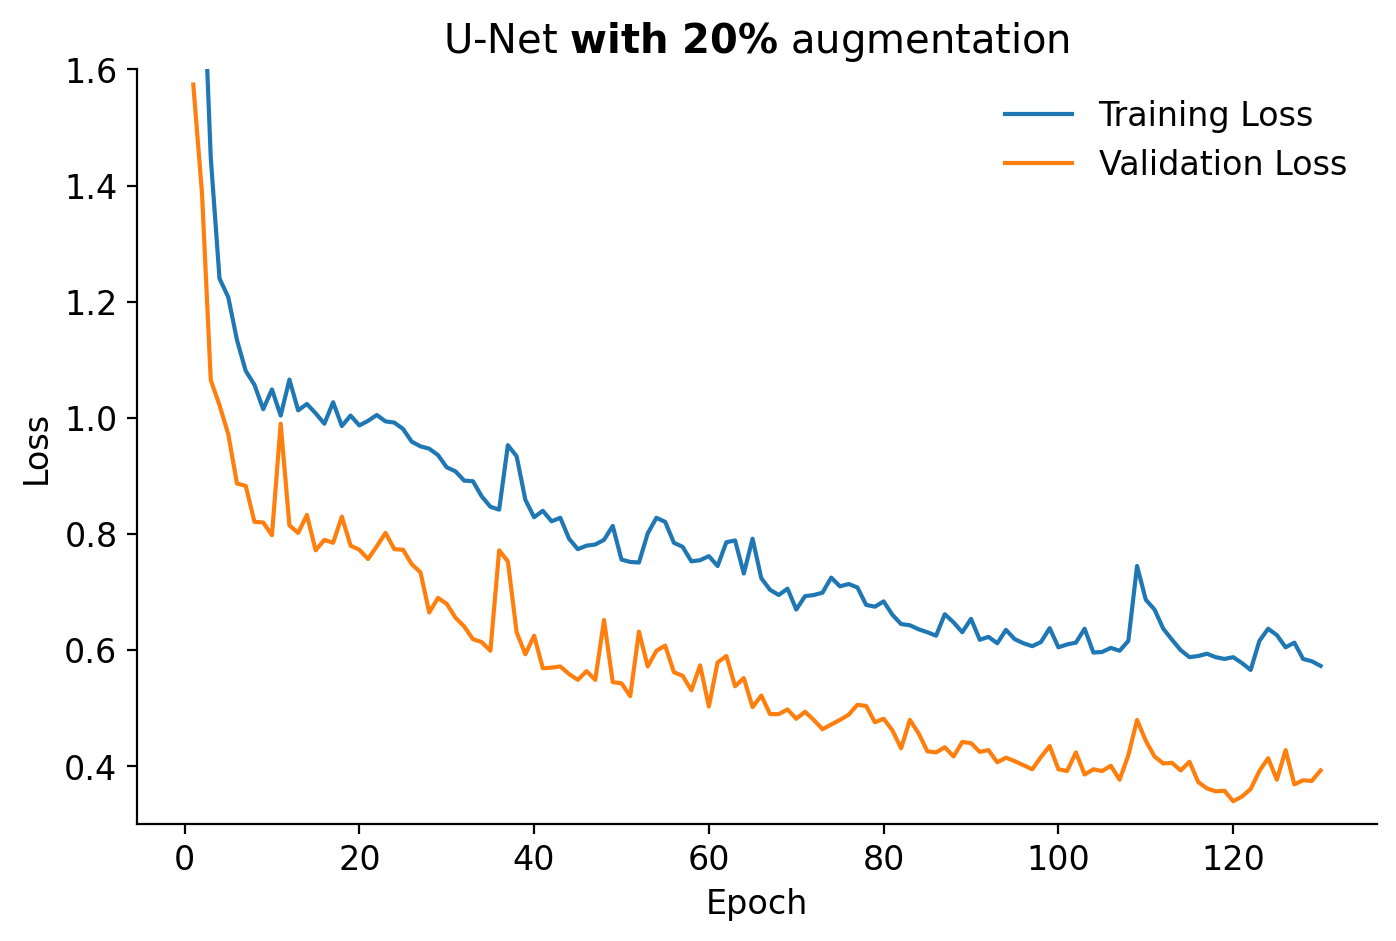

In [ ]:
#lr 0.005, patience 10 

#Q: why is validation loss less than training?

#Q: compare convergence against augmented ver
plt.rcParams.update({'font.size': 12})

fig , axes = plt.subplots(1, 1, figsize=(8, 5))

axes.set_ylim([0.3, 1.6])
axes.plot(table['epoch'], table['train loss'], label = 'Training Loss')
axes.plot(table['epoch'], table['valid loss'], label = 'Validation Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend(fontsize=12, frameon=False, prop={'size': 12})
plt.title(r"U-Net $\bf{with \ 20\%}$ augmentation")
sns.despine()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/mri_models/Fig_aug.png", 
               bbox_inches='tight', dpi = 200, facecolor="white")

plt.show()

In [ ]:
#test set DICE
dice = 0.0; bce = 0.0

num_samples = len(test_loader.dataset); bce_loss = nn.BCEWithLogitsLoss()
for i, (t2, mask) in enumerate(test_loader):
    t2 = t2.to(device);  mask = mask.to(device, dtype = torch.float)
        
    with torch.no_grad():  # sure that we will not backpropagate
              
        mask_hat = unet(t2) #logits
            
        bce += bce_loss(mask_hat, mask)*(t2.shape[0]/num_samples)
        dice += dice_loss(torch.sigmoid(mask_hat), mask)*(t2.shape[0]/num_samples)

print("test bce {}, test dice {}".format(bce, dice))

test bce 0.01256480161100626, test dice 0.3811553418636322


## save models

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/mri_models' + "/unet_aug_003.pth"
print(path)

# Save parameters
#torch.save(unet.state_dict(), path)

/content/drive/MyDrive/Colab Notebooks/mri_models/unet_aug_003.pth


In [ ]:
table.to_csv("/content/drive/MyDrive/Colab Notebooks/mri_models/aug_unet_seed5_lr_003.csv", index = False)

In [ ]:
# Instantiate model
aug_unet = UNet(retain_dim=False).to(device)

# Load saved parameters
aug_unet.load_state_dict(torch.load(path))
aug_unet.eval()

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Block(
        (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-

In [ ]:
test_recons = torch.sigmoid(aug_unet(t2_vis));

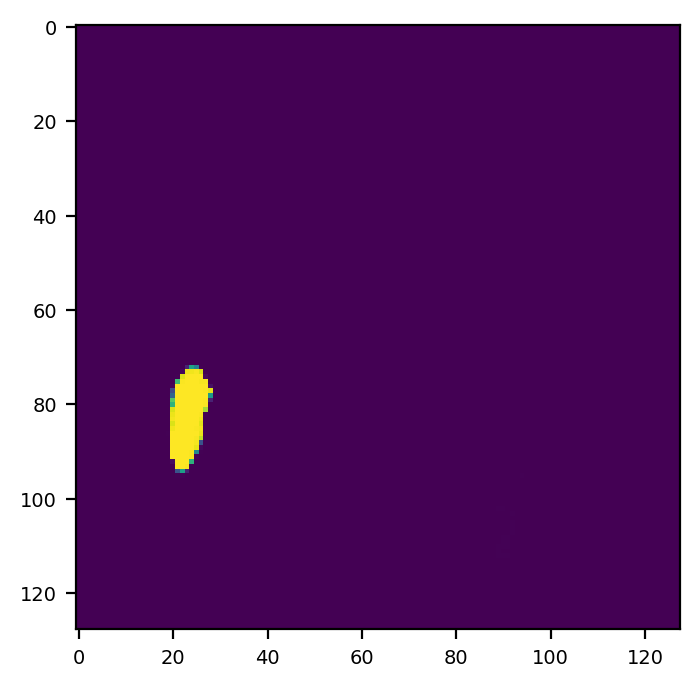

In [ ]:
plt.imshow(test_recons[0][0].cpu().detach().numpy())

## K-fold cross validation

One limitation of the above, is that we have only run the models on choice of the training/test/validation split. What if we had chosen a different split? 

Here, we do 5-fold cross validation. We also find that there is no difference between the augmentation and without. 

In [ ]:
#Group k-fold. Each patient appears only once in the test set 
import numpy as np
from sklearn.model_selection import GroupKFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
# y = np.array([1, 2, 3, 4, 5, 6])
groups = np.array([0, 0, 2, 2, 3, 3])
group_kfold = GroupKFold(n_splits=2)

In [ ]:
import numpy as np
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader

group_kfold = GroupKFold(n_splits=5)

my_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128, 128))])

table_list = []

for i, (train_index, test_index) in enumerate(group_kfold.split(X = np.zeros(shape = len(t1_arrays)), y = None, groups = patient_labels)): #note, use ANY data for X, as long as same dim. We're only interested in indexes
  print(f"Fold {i}:")
     
  #print(f"  Train: index={train_index}") 
  #print(len(train_index))
  print(f"Train patients = { list(dict.fromkeys(np.array(patient_labels)[train_index]))}")
  #print(f"  Test: index={test_index}") 
  #print(len(test_index))
  print(f"Test patients = { list(dict.fromkeys(np.array(patient_labels)[test_index]))}")
  
  print(set(train_index).isdisjoint(test_index))
  #print(np.mean(train_index))
  train_loader = DataLoader(ISPY_dataset(t2_arrays[train_index], mask_arrays[train_index], 
                          my_transforms), batch_size = 128, shuffle=True)
  
  test_loader = DataLoader(ISPY_dataset(t2_arrays[test_index], mask_arrays[test_index], 
                          my_transforms), batch_size = 128, shuffle=True)
  
  print("augmented")
  #note: setting torch.manual_seed() as the same seed all the time, sometimes the models have exactly the same performance on different iterations
  #probably because we are 5-splitting on the patient level, and there are only 100 patients => training sets per iteration are very similiar
  #so instead we vary the model weights per iteration, but make sure to have the same weights between both the ori and augmented batches. 
  torch.manual_seed(i)
  unet = UNet(retain_dim=False).to(device)
  unet, table = train(unet, train_loader, test_loader, epochs = 80, lr = 0.005, augment_batch = True, prop = 0.2)
  table['augment_prop'] = 0.2; table["fold"] = i; table_list.append(table)

  print("\nOriginal")
  torch.manual_seed(i)
  unet = UNet(retain_dim=False).to(device)
  unet, table = train(unet, train_loader, test_loader, epochs = 80, lr = 0.005, augment_batch = False)
  table['augment_prop'] = 0.0; table["fold"] = i; table_list.append(table)

     

Fold 0:
Train patients = ['ACRIN-6698-102212', 'ACRIN-6698-104268', 'ACRIN-6698-107700', 'ACRIN-6698-116603', 'ACRIN-6698-130580', 'ACRIN-6698-144302', 'ACRIN-6698-146987', 'ACRIN-6698-148357', 'ACRIN-6698-150547', 'ACRIN-6698-156163', 'ACRIN-6698-162562', 'ACRIN-6698-179369', 'ACRIN-6698-196064', 'ACRIN-6698-209967', 'ACRIN-6698-220471', 'ACRIN-6698-220925', 'ACRIN-6698-233191', 'ACRIN-6698-255388', 'ACRIN-6698-266840', 'ACRIN-6698-275034', 'ACRIN-6698-275626', 'ACRIN-6698-280375', 'ACRIN-6698-283070', 'ACRIN-6698-289420', 'ACRIN-6698-317402', 'ACRIN-6698-326433', 'ACRIN-6698-329076', 'ACRIN-6698-362150', 'ACRIN-6698-373346', 'ACRIN-6698-378885', 'ACRIN-6698-383456', 'ACRIN-6698-384830', 'ACRIN-6698-413211', 'ACRIN-6698-414844', 'ACRIN-6698-430441', 'ACRIN-6698-462582', 'ACRIN-6698-490023', 'ACRIN-6698-490805', 'ACRIN-6698-520471', 'ACRIN-6698-524170', 'ACRIN-6698-530095', 'ACRIN-6698-531988', 'ACRIN-6698-547405', 'ACRIN-6698-547892', 'ACRIN-6698-571995', 'ACRIN-6698-573605', 'ACRIN-6

KeyboardInterrupt: ignored

In [ ]:
bigtable = pd.concat(table_list, ignore_index=True, axis=0)
bigtable.to_csv("/content/drive/MyDrive/Colab Notebooks/mri_models/ori_vs_aug_CV_v4.csv", index = False)
#v3 perturbed the latent points using errors ~ N(0,1)
#v4 uses errors ~ N(0,1/2)

In [ ]:
bigtable = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mri_models/ori_vs_aug_CV_v4.csv"); bigtable = bigtable[bigtable['train loss'] != 0.0]
bigtable

,epoch,train loss,train dice,train bce,valid loss,valid dice,valid bce,augment_prop,fold
0,1,1.540,0.997,0.471,1.606,0.996,0.610,0.2,0
1,2,1.157,0.989,0.022,1.012,0.989,0.023,0.2,0
2,3,0.987,0.944,0.017,0.903,0.889,0.014,0.2,0
3,4,0.926,0.934,0.017,0.878,0.863,0.015,0.2,0
4,5,0.934,0.931,0.018,0.844,0.830,0.015,0.2,0
...,...,...,...,...,...,...,...,...,...
795,76,0.511,0.573,0.012,0.440,0.427,0.014,0.0,4
796,77,0.484,0.408,0.013,0.428,0.414,0.013,0.0,4
797,78,0.484,0.389,0.012,0.412,0.399,0.014,0.0,4
798,79,0.485,0.380,0.010,0.415,0.402,0.013,0.0,4


In [ ]:
bigtable = bigtable.rename(columns={"fold": "Iteration", "valid loss": "Loss on Test Fold"})

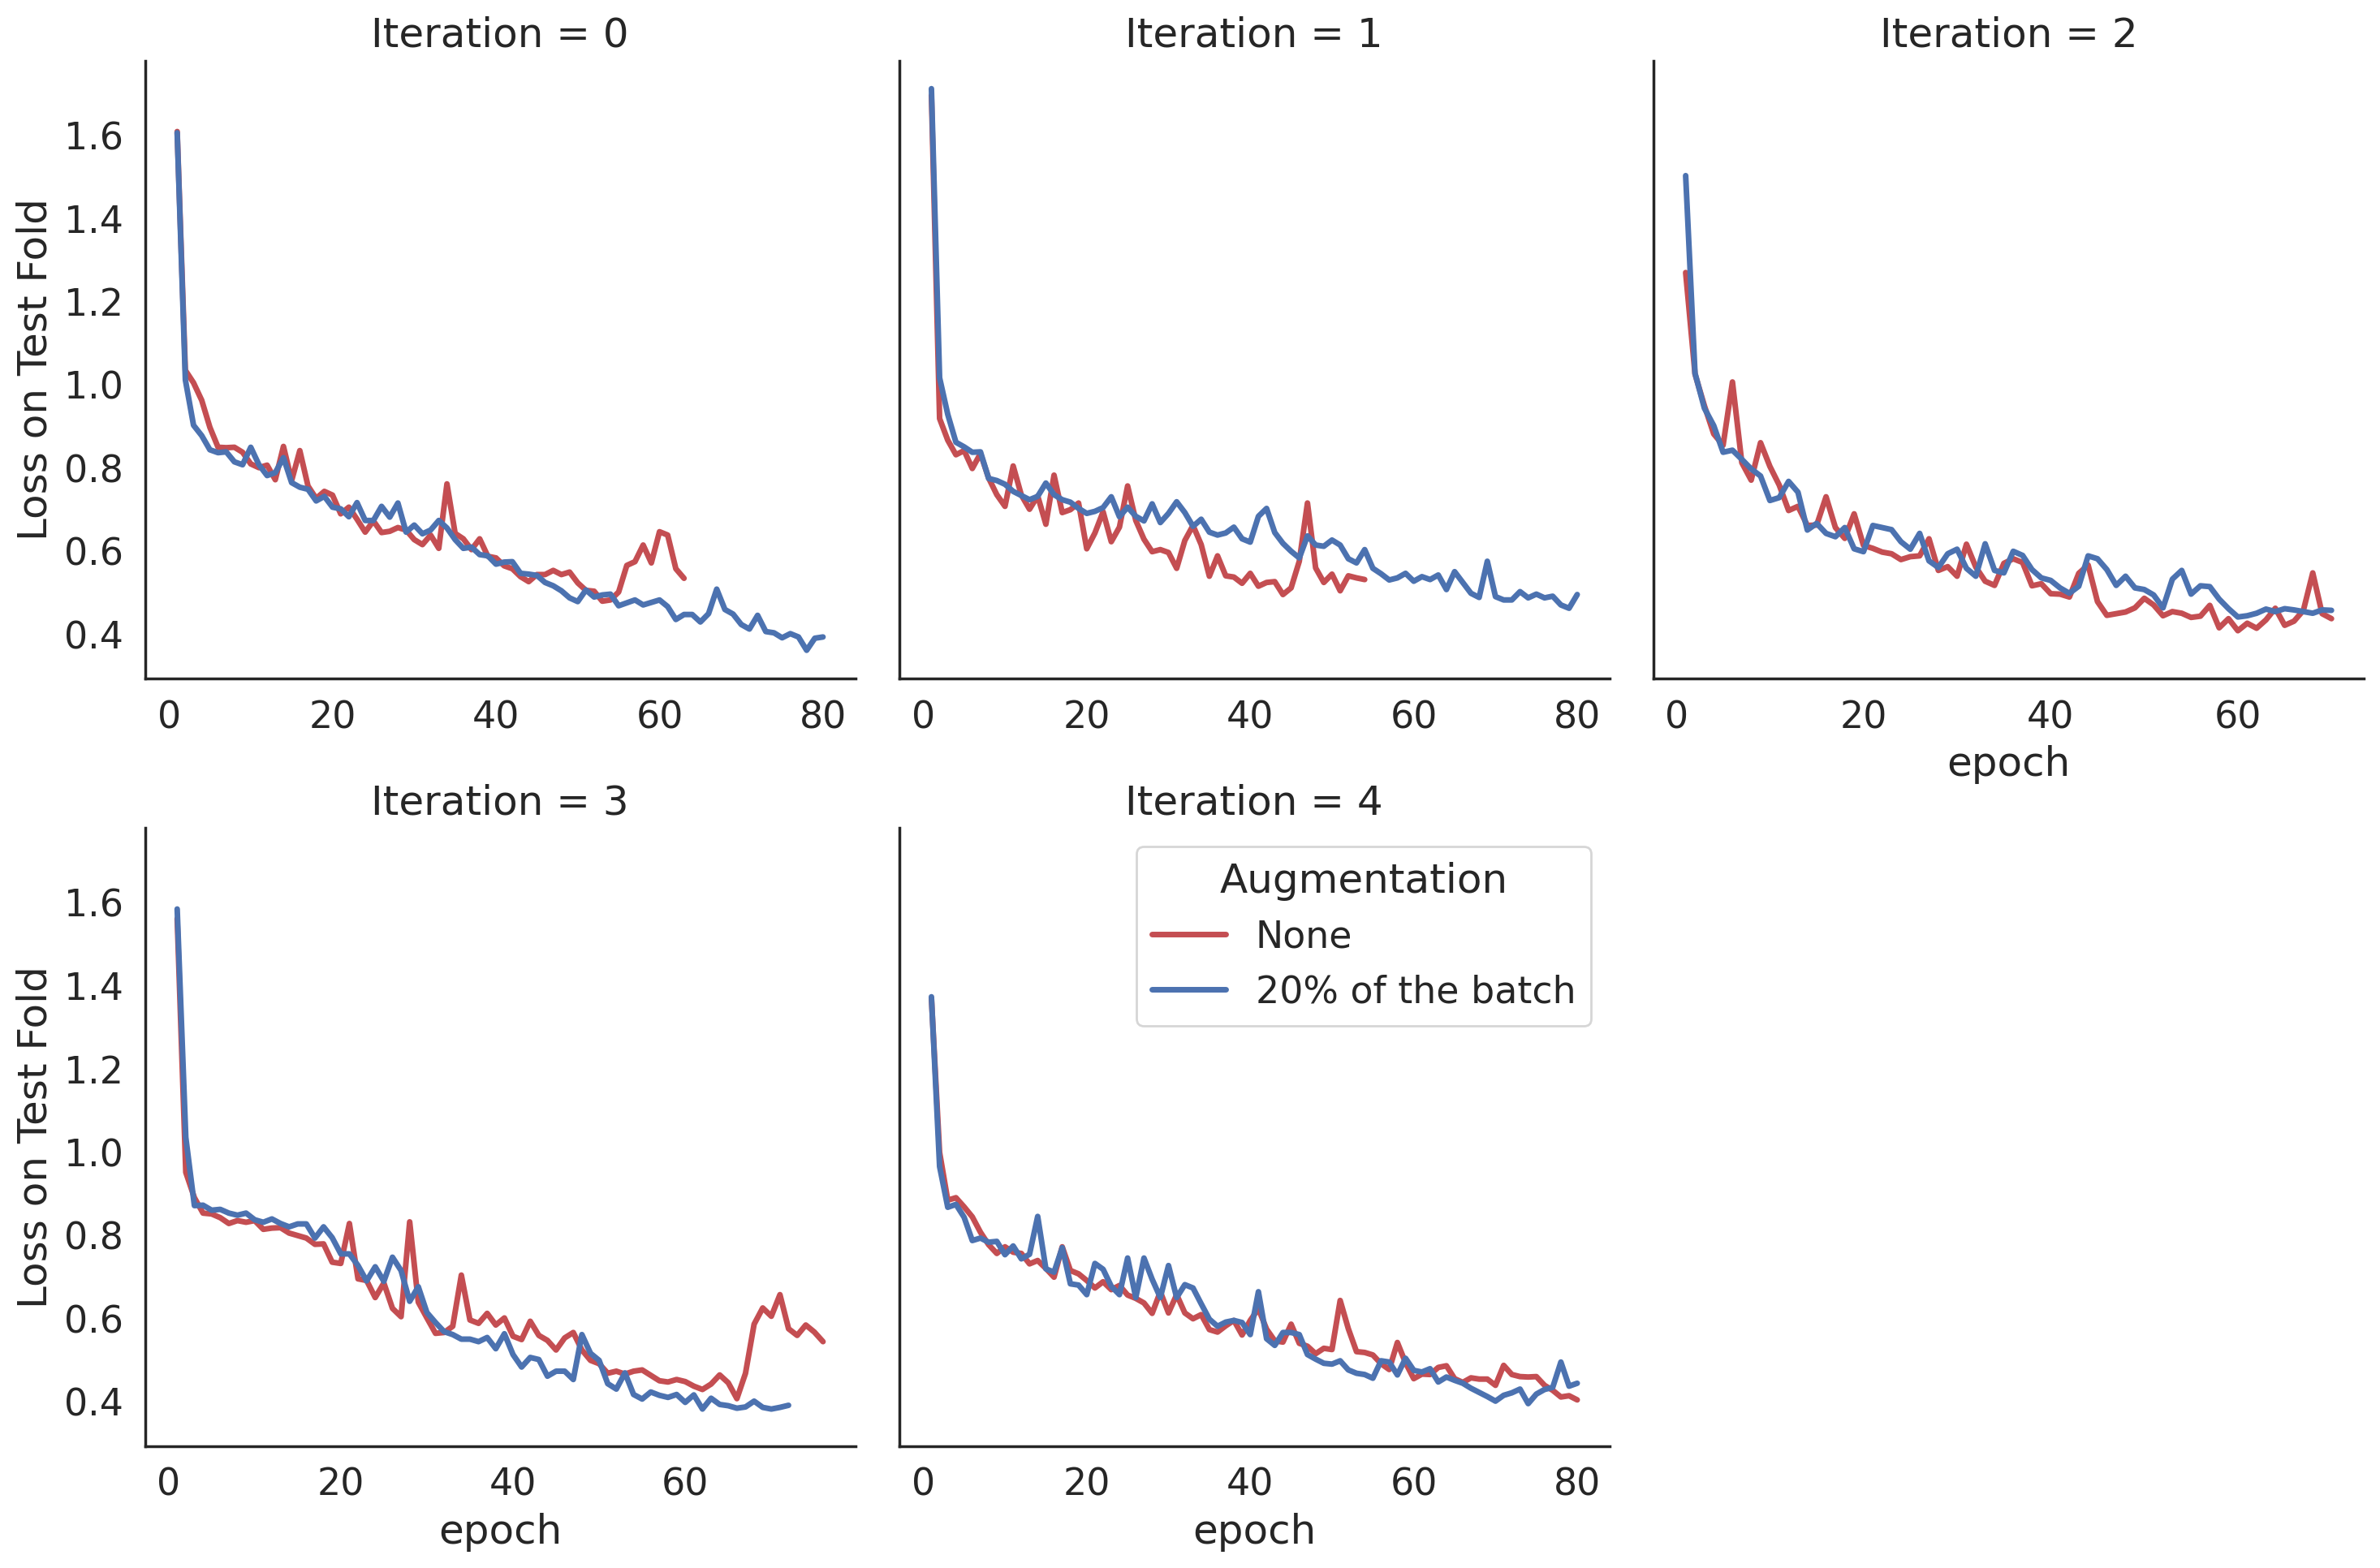

In [ ]:
#V4

sns.set(style="white", font_scale=1.5)

sns_plot = sns.relplot(
    data=bigtable,
    x="epoch", y= "Loss on Test Fold", kind ="line", hue = "augment_prop", col="Iteration", col_wrap = 3, facet_kws=dict(sharex=False),
    palette=['r', 'b'], linewidth=2.5, legend = False
)

plt.legend(title='Augmentation', loc='upper right', labels=['None', '20% of the batch'])

sns_plot.savefig("/content/drive/MyDrive/Colab Notebooks/mri_models/5cv.png", dpi = 200) 

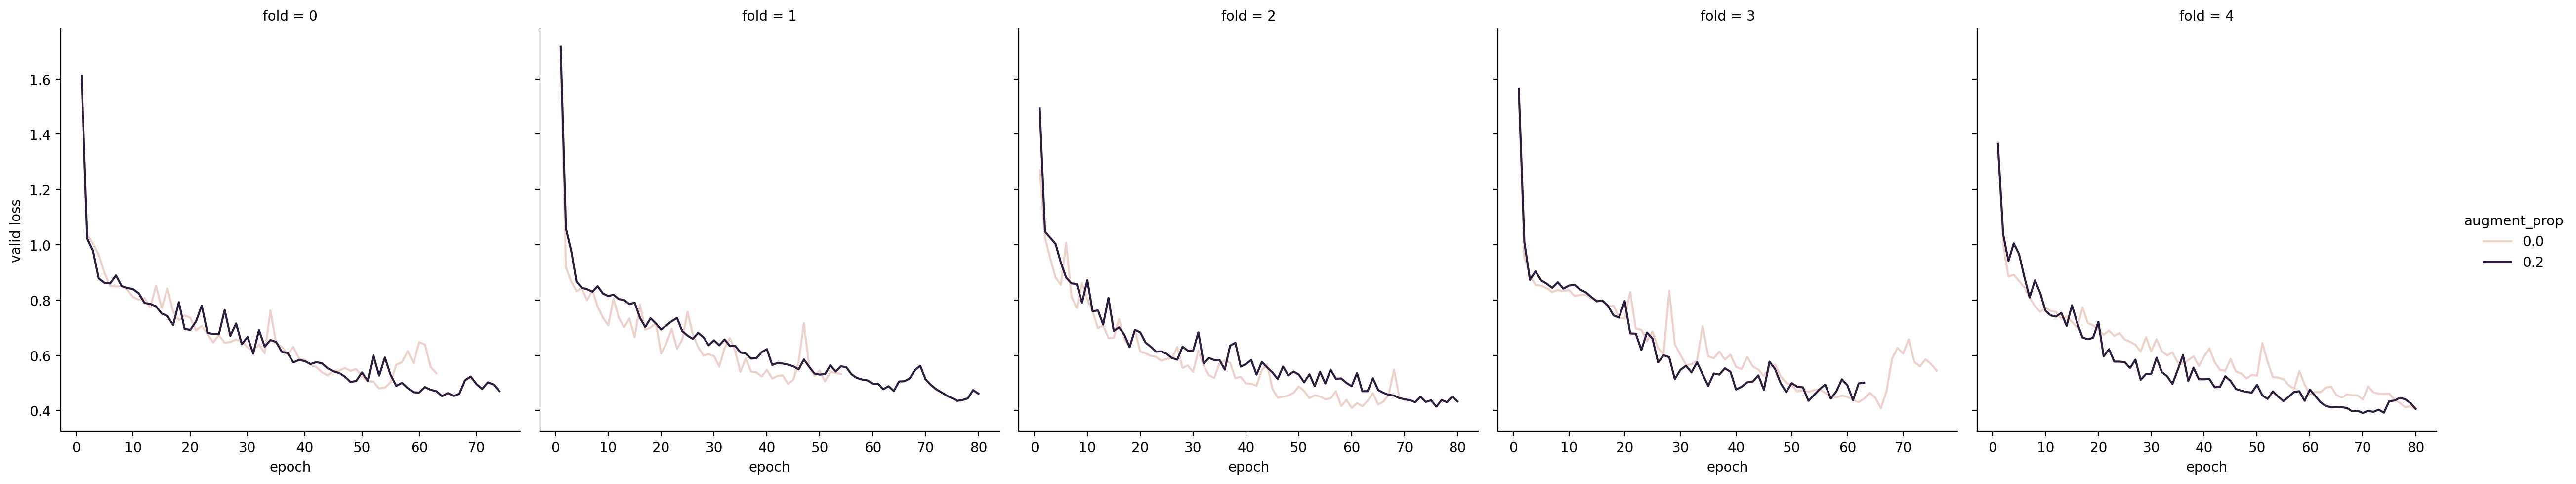

In [ ]:
#V3
sns.relplot(
    data=bigtable,
    x="epoch", y="valid loss", kind ="line", hue = "augment_prop", col="fold", facet_kws=dict(sharex=False),
)

#James: try to decide what is the peak amount of augmentation to do, before augmentation makes it worse. 

# the below are not used

In [ ]:
seeds = [1,2,3,4,6,7]
table_list = []


for seed in seeds: 
  torch.manual_seed(seed); unet = UNet(retain_dim=False).to(device)
  torch.manual_seed(seed); unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.008, augment_batch = True, prop = 0)
  table['prop'] = 0; table_list.append(table)

  torch.manual_seed(seed); unet = UNet(retain_dim=False).to(device)
  torch.manual_seed(seed); unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.008, augment_batch = True, prop = 0.2)
  table['prop'] = 0.2;  table_list.append(table)



Streaming output truncated to the last 5000 lines.
batch 4 size 128 loss 0.74668 DICE: 0.72547 BCE 0.021206
batch 5 size 128 loss 0.77518 DICE: 0.75364 BCE 0.021541
batch 6 size 128 loss 0.72708 DICE: 0.70739 BCE 0.019687
batch 7 size 128 loss 0.79897 DICE: 0.78166 BCE 0.017304
batch 8 size 128 loss 0.7849 DICE: 0.76857 BCE 0.016324
batch 9 size 61 loss 0.79171 DICE: 0.76873 BCE 0.022983
validation loss 0.66062 DICE 0.6352 BCE 0.02539

epoch: 16
batch 0 size 128 loss 0.70566 DICE: 0.68122 BCE 0.024431
batch 1 size 128 loss 0.739 DICE: 0.70992 BCE 0.029078
batch 2 size 128 loss 0.81754 DICE: 0.79111 BCE 0.026422
batch 3 size 128 loss 0.92688 DICE: 0.88798 BCE 0.038892
batch 4 size 128 loss 0.8125 DICE: 0.78518 BCE 0.027326
batch 5 size 128 loss 0.72502 DICE: 0.70478 BCE 0.020247
batch 6 size 128 loss 0.79434 DICE: 0.78253 BCE 0.011803
batch 7 size 128 loss 0.90081 DICE: 0.88381 BCE 0.017001
batch 8 size 128 loss 0.85202 DICE: 0.83549 BCE 0.016525
batch 9 size 61 loss 0.77472 DICE: 0.744

In [ ]:
bigtable2 = pd.concat(table_list, ignore_index=True, axis=0); bigtable2
#bigtable2.to_csv("big_results.csv", index = False)

In [ ]:
bigtable2 = pd.read_csv("big_results.csv")

In [ ]:
bigtable2['seed'] = list(np.repeat([1,2,3,4], 100))
table = bigtable2[bigtable2['epoch'].between(40, 50)]; table

,epoch,train loss,train dice,train bce,valid loss,valid dice,valid bce,prop,seed
39,40,0.636,0.670,0.016,0.594,0.576,0.018,0.0,1
40,41,0.633,0.627,0.013,0.556,0.536,0.020,0.0,1
41,42,0.629,0.577,0.015,0.558,0.542,0.016,0.0,1
42,43,0.626,0.532,0.016,0.566,0.545,0.020,0.0,1
43,44,0.623,0.555,0.018,0.547,0.530,0.017,0.0,1
...,...,...,...,...,...,...,...,...,...
395,46,0.792,0.845,0.028,0.725,0.702,0.024,0.2,4
396,47,0.796,0.849,0.023,0.707,0.688,0.019,0.2,4
397,48,0.782,0.838,0.024,0.713,0.691,0.022,0.2,4
398,49,0.791,0.834,0.023,0.706,0.687,0.018,0.2,4


In [ ]:
table.groupby(['seed', 'prop']).mean()

epoch  train loss  train dice  train bce  valid loss  valid dice  \
seed prop                                                                     
1    0.0    45.0    0.624091    0.600091   0.015636    0.559545    0.541273   
     0.2    45.0    0.770545    0.814000   0.022909    0.675091    0.655545   
2    0.0    45.0    0.614091    0.588273   0.015727    0.546364    0.528000   
     0.2    45.0    0.677364    0.720091   0.021636    0.545727    0.526636   
3    0.0    45.0    0.592091    0.587364   0.017818    0.502545    0.484545   
     0.2    45.0    0.672727    0.734909   0.022636    0.561182    0.542545   
4    0.0    45.0    0.671000    0.690727   0.012273    0.606727    0.595364   
     0.2    45.0    0.798909    0.850000   0.025818    0.722455    0.701636   

           valid bce  
seed prop             
1    0.0    0.018091  
     0.2    0.019545  
2    0.0    0.018545  
     0.2    0.019091  
3    0.0    0.018273  
     0.2    0.018455  
4    0.0    0.011545  
     0.2    0.021000

## Scenario: different augmentation proportions

In [ ]:
props = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
table_list = []

for prop in props:
  print("prop:", prop)
  
  torch.manual_seed(5) 
  unet = UNet(retain_dim=False).to(device)
  unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.008, augment_batch = True, prop = prop)
  table["augment_prop"] = prop; table_list.append(table)



prop: 0
epoch: 0
batch 0 size 128 loss 1.6923 DICE: 0.99479 BCE 0.69749
batch 1 size 128 loss 1.6441 DICE: 0.99723 BCE 0.64689
batch 2 size 128 loss 1.6 DICE: 0.99754 BCE 0.60251
batch 3 size 128 loss 1.5702 DICE: 0.99669 BCE 0.57348
batch 4 size 128 loss 1.5616 DICE: 0.99811 BCE 0.56352
batch 5 size 128 loss 1.5259 DICE: 0.99676 BCE 0.52915
batch 6 size 128 loss 1.5094 DICE: 0.99747 BCE 0.51191
batch 7 size 128 loss 1.4957 DICE: 0.99744 BCE 0.49826
batch 8 size 128 loss 1.4817 DICE: 0.99772 BCE 0.48401
batch 9 size 61 loss 1.4625 DICE: 0.99825 BCE 0.46422
validation loss 1.434 DICE 0.9995 BCE 0.4345

epoch: 1
batch 0 size 128 loss 1.4157 DICE: 0.99943 BCE 0.41624
batch 1 size 128 loss 1.1064 DICE: 0.99911 BCE 0.10725
batch 2 size 128 loss 1.287 DICE: 0.99992 BCE 0.28713
batch 3 size 128 loss 1.0783 DICE: 0.99923 BCE 0.079067
batch 4 size 128 loss 1.0395 DICE: 0.99781 BCE 0.041731
batch 5 size 128 loss 1.0098 DICE: 0.97899 BCE 0.03083
batch 6 size 128 loss 1.0439 DICE: 0.99982 BCE 0.04

KeyboardInterrupt: ignored

In [ ]:
big_table = pd.concat(table_list, ignore_index=True, axis=0); big_table

,epoch,train loss,train dice,train bce,valid loss,valid dice,valid bce,augment_prop
0,1,1.678,0.996,0.584,1.855,0.994,0.861,0.0
1,2,1.442,0.999,0.071,1.024,0.998,0.026,0.0
2,3,1.029,0.999,0.017,1.030,1.000,0.030,0.0
3,4,0.998,0.937,0.009,0.929,0.919,0.009,0.0
4,5,0.914,0.900,0.013,0.865,0.847,0.017,0.0
...,...,...,...,...,...,...,...,...
295,46,0.785,0.721,0.021,0.604,0.589,0.015,0.5
296,47,0.782,0.719,0.024,0.607,0.590,0.017,0.5
297,48,0.775,0.721,0.022,0.621,0.604,0.017,0.5
298,49,0.772,0.709,0.024,0.576,0.559,0.017,0.5


## Scenario: smaller datasets

`test_loader` is fine: use the same patients as validation. But here we shrink `train_loader`, by choosing diff number of patients. 

In [ ]:
patient_no = [10, 30, 50, 70]
import random
print(len(train_p)) # the patients we chose for training

my_transforms = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize((128, 128))
  ])

81


In [ ]:
table_list = []

#take the first 20 patients, over diff random seeds

for s in range(30):  
  random.seed(s) 
  patients = random.sample(train_p, 20); print(patients)
  train_indexes = [e in patients for e in patient_labels]
  print("train prop:", sum(train_indexes)/len(train_indexes),
      "train size:", sum(train_indexes)) 

  train_data = ISPY_dataset(t1_arrays[train_indexes], t2_arrays[train_indexes], mask_arrays[train_indexes],
                          my_transforms)
  train_loader = DataLoader(train_data, batch_size = 128, shuffle=True);


  unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.005, augment_batch = True)
  table["augment"] = False
  table_list.append(table)

  unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.005, augment_batch = True)
  table["augment"] = True
  table_list.append(table)

['ACRIN-6698-220471', 'ACRIN-6698-520471', 'ACRIN-6698-618717', 'ACRIN-6698-524170', 'ACRIN-6698-209967', 'ACRIN-6698-150547', 'ACRIN-6698-467686', 'ACRIN-6698-609151', 'ACRIN-6698-775346', 'ACRIN-6698-748611', 'ACRIN-6698-237158', 'ACRIN-6698-771443', 'ACRIN-6698-490023', 'ACRIN-6698-748583', 'ACRIN-6698-573605', 'ACRIN-6698-383456', 'ACRIN-6698-430441', 'ACRIN-6698-373346', 'ACRIN-6698-240957', 'ACRIN-6698-220925']
train prop: 0.20574482297929192 train size: 308
epoch: 0
batch 0 size 128 loss 0.17107 DICE: 0.16389 BCE 0.0071847
batch 1 size 128 loss 0.24241 DICE: 0.23128 BCE 0.011127
batch 2 size 52 loss 0.18356 DICE: 0.17868 BCE 0.0048747
validation loss 0.1694 DICE 0.1626 BCE 0.006793

epoch: 1
batch 0 size 128 loss 0.17762 DICE: 0.1708 BCE 0.0068204
batch 1 size 128 loss 0.18007 DICE: 0.17335 BCE 0.0067152
batch 2 size 52 loss 0.15093 DICE: 0.14468 BCE 0.0062426
validation loss 0.17719 DICE 0.1705 BCE 0.006728

epoch: 2
batch 0 size 128 loss 0.17511 DICE: 0.16834 BCE 0.0067619
bat

KeyboardInterrupt: ignored

In [ ]:
table_list = []

for n in patient_no:  
  random.seed(5) 
  train_indexes = [e in train_p[:n] for e in patient_labels]
  print("train prop:", sum(train_indexes)/len(train_indexes),
      "train size:", sum(train_indexes)) 

  train_data = ISPY_dataset(t1_arrays[train_indexes], t2_arrays[train_indexes], mask_arrays[train_indexes],
                          my_transforms)
  train_loader = DataLoader(train_data, batch_size = 128, shuffle=True);


  unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.005, augment_batch = False)
  table["augment"] = False; table["patient_no"] = n
  table_list.append(table)

  unet, table = train(unet, train_loader, test_loader, epochs = 50, lr = 0.005, augment_batch = True)
  table["augment"] = True; table["patient_no"] = n
  table_list.append(table)

train prop: 0.11823647294589178 train size: 177
epoch: 0
batch 0 size 128 loss 0.10205 DICE: 0.097572 BCE 0.0044754
batch 1 size 49 loss 0.31302 DICE: 0.30221 BCE 0.010818
validation loss 0.15234 DICE 0.1462 BCE 0.006104

epoch: 1
batch 0 size 128 loss 0.11896 DICE: 0.11346 BCE 0.0054958
batch 1 size 49 loss 0.20061 DICE: 0.19339 BCE 0.0072262
validation loss 0.23911 DICE 0.2285 BCE 0.01061

epoch: 2
batch 0 size 128 loss 0.19643 DICE: 0.18791 BCE 0.0085176
batch 1 size 49 loss 0.2068 DICE: 0.19671 BCE 0.010093
validation loss 0.2691 DICE 0.2586 BCE 0.01046

epoch: 3
batch 0 size 128 loss 0.21099 DICE: 0.20346 BCE 0.0075283
batch 1 size 49 loss 0.17641 DICE: 0.1663 BCE 0.010112
validation loss 0.21907 DICE 0.2109 BCE 0.00819

epoch: 4
batch 0 size 128 loss 0.1562 DICE: 0.14892 BCE 0.0072812
batch 1 size 49 loss 0.17395 DICE: 0.16858 BCE 0.0053711
validation loss 0.19947 DICE 0.1921 BCE 0.007409

epoch: 5
batch 0 size 128 loss 0.14297 DICE: 0.13585 BCE 0.0071199
batch 1 size 49 loss 0.1

KeyboardInterrupt: ignored

## Old version: generate points from N(0,1) then decode

In [ ]:
# torch.manual_seed(9) 
# points = torch.distributions.Normal(0, 1).sample((250, 32, 4, 4)).to(device) #sample 250 points from the latent space
# points.shape

# new_t2 = vae.t2_decoder(points).detach().cpu()

# new_masks = vae.mask_decoder(points).detach().cpu()
# print(new_t2.shape, new_masks.shape)

torch.Size([250, 1, 128, 128]) torch.Size([250, 1, 128, 128])


In [ ]:
# for i in range(8):    
#     fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
#     fig.set_size_inches(5, 5)
#     fig.tight_layout()
#     ax[0].imshow(new_t2[i][0].numpy(), vmin = torch.min(t2_vis), vmax = torch.max(t2_vis))
#     ax[1].imshow(new_masks[i][0].numpy(), vmin = torch.min(mask_vis), vmax = torch.max(mask_vis))
#     #ax[i,0].set_aspect('equal'); ax[i,1].set_aspect('equal')
#     plt.xticks([]); plt.yticks([]); plt.show()
  

In [ ]:
# import pickle 

# #LOAD
# with open('/content/drive/MyDrive/Colab Notebooks/mri_models/new_t2.pkl', 'rb') as f: 
#     new_t2 = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/mri_models/new_masks.pkl', 'rb') as f:
#     new_masks = pickle.load(f)


In [ ]:
train_prop = 0.8 #take 0.8 of patients for training

import random; random.seed(4) 
unique_p = list(dict.fromkeys(patient_labels)) #preserve order
train_p = random.sample(unique_p, 
                        int(train_prop*len(unique_p)))
print(len(train_p))

train_indexes = [e in train_p for e in patient_labels]
print("train prop:", sum(train_indexes)/len(train_indexes),
      "train size:", sum(train_indexes)) #0.8 of the data for training

def get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes):
  z_dim = len(train_indexes)
  test_indexes = [not e for e in train_indexes]
  return t1_arrays[train_indexes], t2_arrays[train_indexes], mask_arrays[train_indexes], t1_arrays[test_indexes], t2_arrays[test_indexes], mask_arrays[test_indexes]


train_t1, train_t2, train_mask, test_t1, test_t2, test_mask = get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes)
print(train_t1.shape)
print(test_t1.shape)

81
train prop: 0.8102872411489646 train size: 1213
(1213, 320, 512)
(284, 320, 512)


In [ ]:
from torch.utils.data import Dataset

#respecify the class, since we only have access here to the t2 and masks
class ISPY_dataset(Dataset):

  def __init__(self, t2_arrays, mask_arrays,
                     transforms):
    self.t2_arrays = t2_arrays
    self.mask_arrays = mask_arrays
    self.transforms = transforms

  def __len__(self):
    return self.t2_arrays.shape[0]

  def __getitem__(self, idx):
    t2 = t2_arrays[idx]; mask = mask_arrays[idx]

    ##transform the T1 and T2
    if self.transforms is not None: 
      t2 = self.transforms(t2)
      mask = self.transforms(mask)

    return (t2, mask)

In [ ]:
print(train_t2.shape)
print(new_t2.shape)
print(new_t2[:,0,:,:].shape)
#they are different sizes. 

new_t2np = new_t2[:,0,:,:].detach().numpy()

(1213, 320, 512)
torch.Size([250, 1, 128, 128])
torch.Size([250, 128, 128])


In [ ]:
from skimage.transform import resize

resized_train_t2 = np.array([resize(img, output_shape = (128, 128)) for img in train_t2]) #resize the training t2
resized_train_t2.shape

(1213, 128, 128)

In [ ]:
t2_cat = np.append(resized_train_t2, new_t2np, axis=0) #then cat
t2_cat.shape

(1463, 128, 128)

In [ ]:
new_masksnp = new_masks[:,0,:,:].detach().numpy()
print(new_masksnp.shape)

resized_train_mask = np.array([resize(img, output_shape = (128, 128)) for img in train_mask]) #resize the training t2

(250, 128, 128)


In [ ]:
masks_cat = np.append(resized_train_mask, new_masksnp, axis=0) #then cat
masks_cat.shape

(1463, 128, 128)

In [ ]:
# define transformations for T1 and T2

train_data = ISPY_dataset(t2_cat, masks_cat, 
                          torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((128, 128))]) #make sure to define the resize again. for some reason, it uses the old sizes
                          )

test_data = ISPY_dataset(test_t2, test_mask, 
                          torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((128, 128))])
                          )

torch.set_printoptions(edgeitems=3)
print(train_data[0]) # t2 and mask
print()
print(train_data[0][0].shape) #each image has 1 channels, and is 128 x 128

(tensor([[[-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         ...,
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int8))

torch.Size([1, 128, 128])


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 128, shuffle=True);
test_loader = DataLoader(test_data, batch_size = 128, shuffle=True)

In [ ]:
torch.manual_seed(3)
t2, mask = next(iter(train_loader))
print(t2.shape, mask.shape)

torch.Size([128, 1, 128, 128]) torch.Size([128, 1, 128, 128])


## train

In [ ]:
def dice_loss(input, target):
  #input and target are tensors
    smooth = 1.

    iflat = input #iflat = input.view(-1)
    tflat = target#tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [ ]:
def validate_one_epoch(autoencoder, loader, recon_loss_fn):
  
    autoencoder.eval()# Set model to evaluation mode
    num_samples = len(loader.dataset) 
    
    dice = 0.0; bce = 0.0
    
    for i, (t2, mask) in enumerate(loader):

        t2 = t2.to(device);  mask = mask.to(device, dtype = torch.float)
        
        with torch.no_grad():  # sure that we will not backpropagate
              
            mask_hat = autoencoder(t2) #logits
            #bce_loss = nn.BCEWithLogitsLoss()
            bce += recon_loss_fn(mask_hat, mask)*(t2.shape[0]/num_samples)

            dice += dice_loss(torch.sigmoid(mask_hat), mask)*(t2.shape[0]/num_samples)        

    return dice, bce

In [ ]:
def train(model, data, valid_data, epochs=3, lr = 0.003, recon_loss_fn = nn.BCEWithLogitsLoss()):
    #early_stopper = EarlyStopper(patience=3, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(model.parameters(), lr) #default lr = 0.001

    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0; table['train dice'] = 0.0; table['train bce'] = 0.0
    table['valid loss'] = 0.0; table['valid dice'] = 0.0; table['valid bce'] = 0.0

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.0

      for i, (t2, mask) in enumerate(data):
            t2 = t2.to(device); mask = mask.to(device,dtype=torch.float)

            opt.zero_grad()

            mask_hat = model(t2) #logits
            bce =  recon_loss_fn(mask_hat, mask)
            dice = dice_loss(torch.sigmoid(mask_hat), mask)
            loss = dice + bce
            
            print("batch {} loss {:.5} DICE: {:.5} BCE {:.5}".format(i, loss.item(), dice.item(), bce.item()))
  
            loss.backward()
            opt.step()

             # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t1.shape[0]/num_samples)

      valid_dice, valid_bce = validate_one_epoch(model, valid_data, recon_loss_fn = recon_loss_fn)
      print("validation loss {:.5} DICE {:.4} BCE {:.4}\n".format(valid_dice + valid_bce, valid_dice, valid_bce))

      table.iloc[epoch, 1] = np.round(train_loss, 3); 
      table.iloc[epoch, 2] = np.round(dice.item(), 3); 
      table.iloc[epoch, 3] = np.round(bce.item(), 3)
      table.iloc[epoch, 4] = np.round((valid_dice + valid_bce).item(), 3); table.iloc[epoch, 5] = np.round((valid_dice).item(), 3); table.iloc[epoch, 6] = np.round((valid_bce).item(), 3)

      # if early_stopper.early_stop(valid_mse + valid_kl):             
      #   break
            
    return unet, table

torch.manual_seed(5) 
unet = UNet(retain_dim=False).to(device)
unet, table = train(unet, train_loader, test_loader, epochs = 60, lr = 0.005)

epoch: 0
batch 0 loss 1.6936 DICE: 0.99511 BCE 0.69854
batch 1 loss 1.6512 DICE: 0.997 BCE 0.65423
batch 2 loss 1.6216 DICE: 0.99767 BCE 0.62397
batch 3 loss 1.5968 DICE: 0.99658 BCE 0.60026
batch 4 loss 1.5749 DICE: 0.9961 BCE 0.57876
batch 5 loss 1.5534 DICE: 0.99696 BCE 0.55643
batch 6 loss 1.5407 DICE: 0.99752 BCE 0.54314
batch 7 loss 1.5269 DICE: 0.99669 BCE 0.5302
batch 8 loss 1.5131 DICE: 0.99722 BCE 0.51588
batch 9 loss 1.4975 DICE: 0.99769 BCE 0.49977
batch 10 loss 1.4802 DICE: 0.99694 BCE 0.48322
batch 11 loss 1.4654 DICE: 0.99693 BCE 0.46846
validation loss 1.6744 DICE 0.9958 BCE 0.6786

epoch: 1
batch 0 loss 1.6739 DICE: 0.99659 BCE 0.67734
batch 1 loss 1.4933 DICE: 0.99684 BCE 0.49645
batch 2 loss 1.4692 DICE: 0.99659 BCE 0.47261
batch 3 loss 1.4284 DICE: 0.99657 BCE 0.43181
batch 4 loss 1.3248 DICE: 0.99774 BCE 0.32702
batch 5 loss 1.1259 DICE: 0.99988 BCE 0.12598
batch 6 loss 1.0991 DICE: 0.99996 BCE 0.099165
batch 7 loss 1.4478 DICE: 0.99979 BCE 0.44803
batch 8 loss 1.0

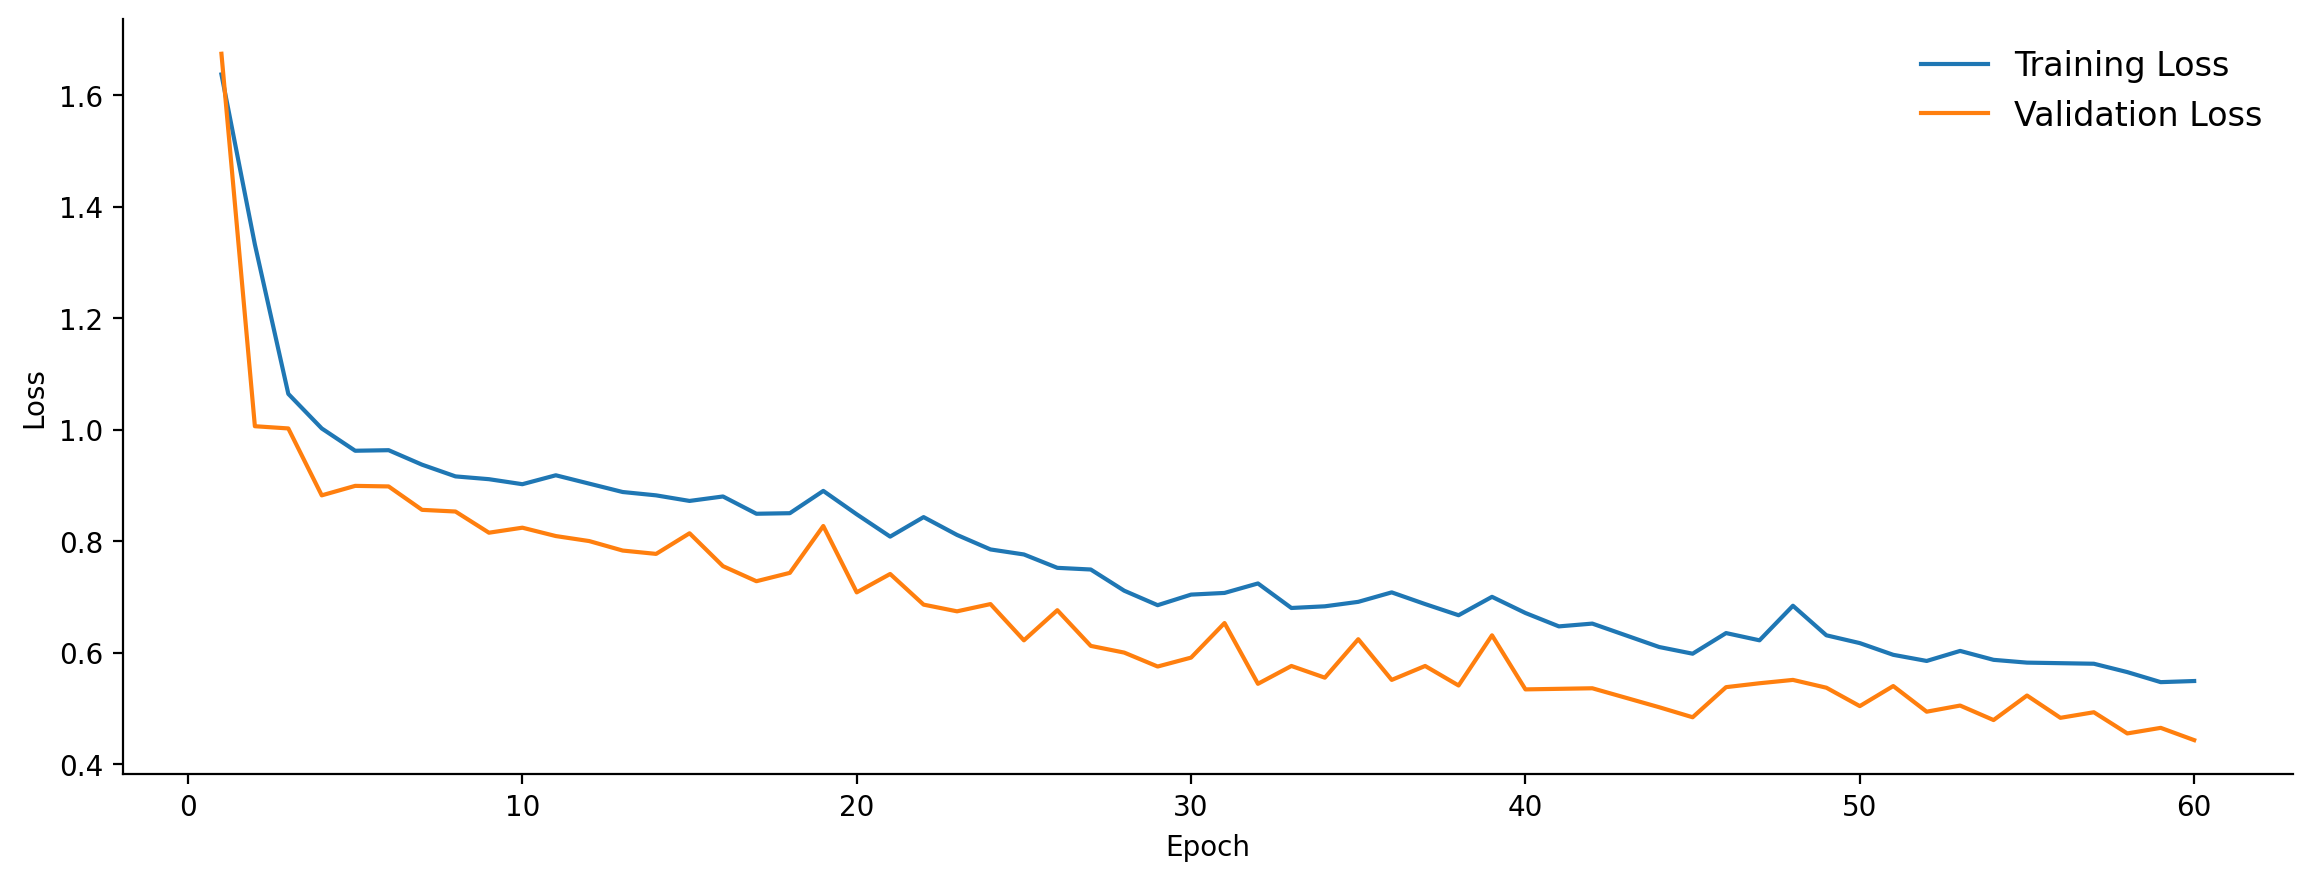

In [ ]:
fig , axes = plt.subplots(1, 1, figsize=(14, 5))
axes.plot(table['epoch'], table['train loss'], label = 'Training Loss')
axes.plot(table['epoch'], table['valid loss'], label = 'Validation Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

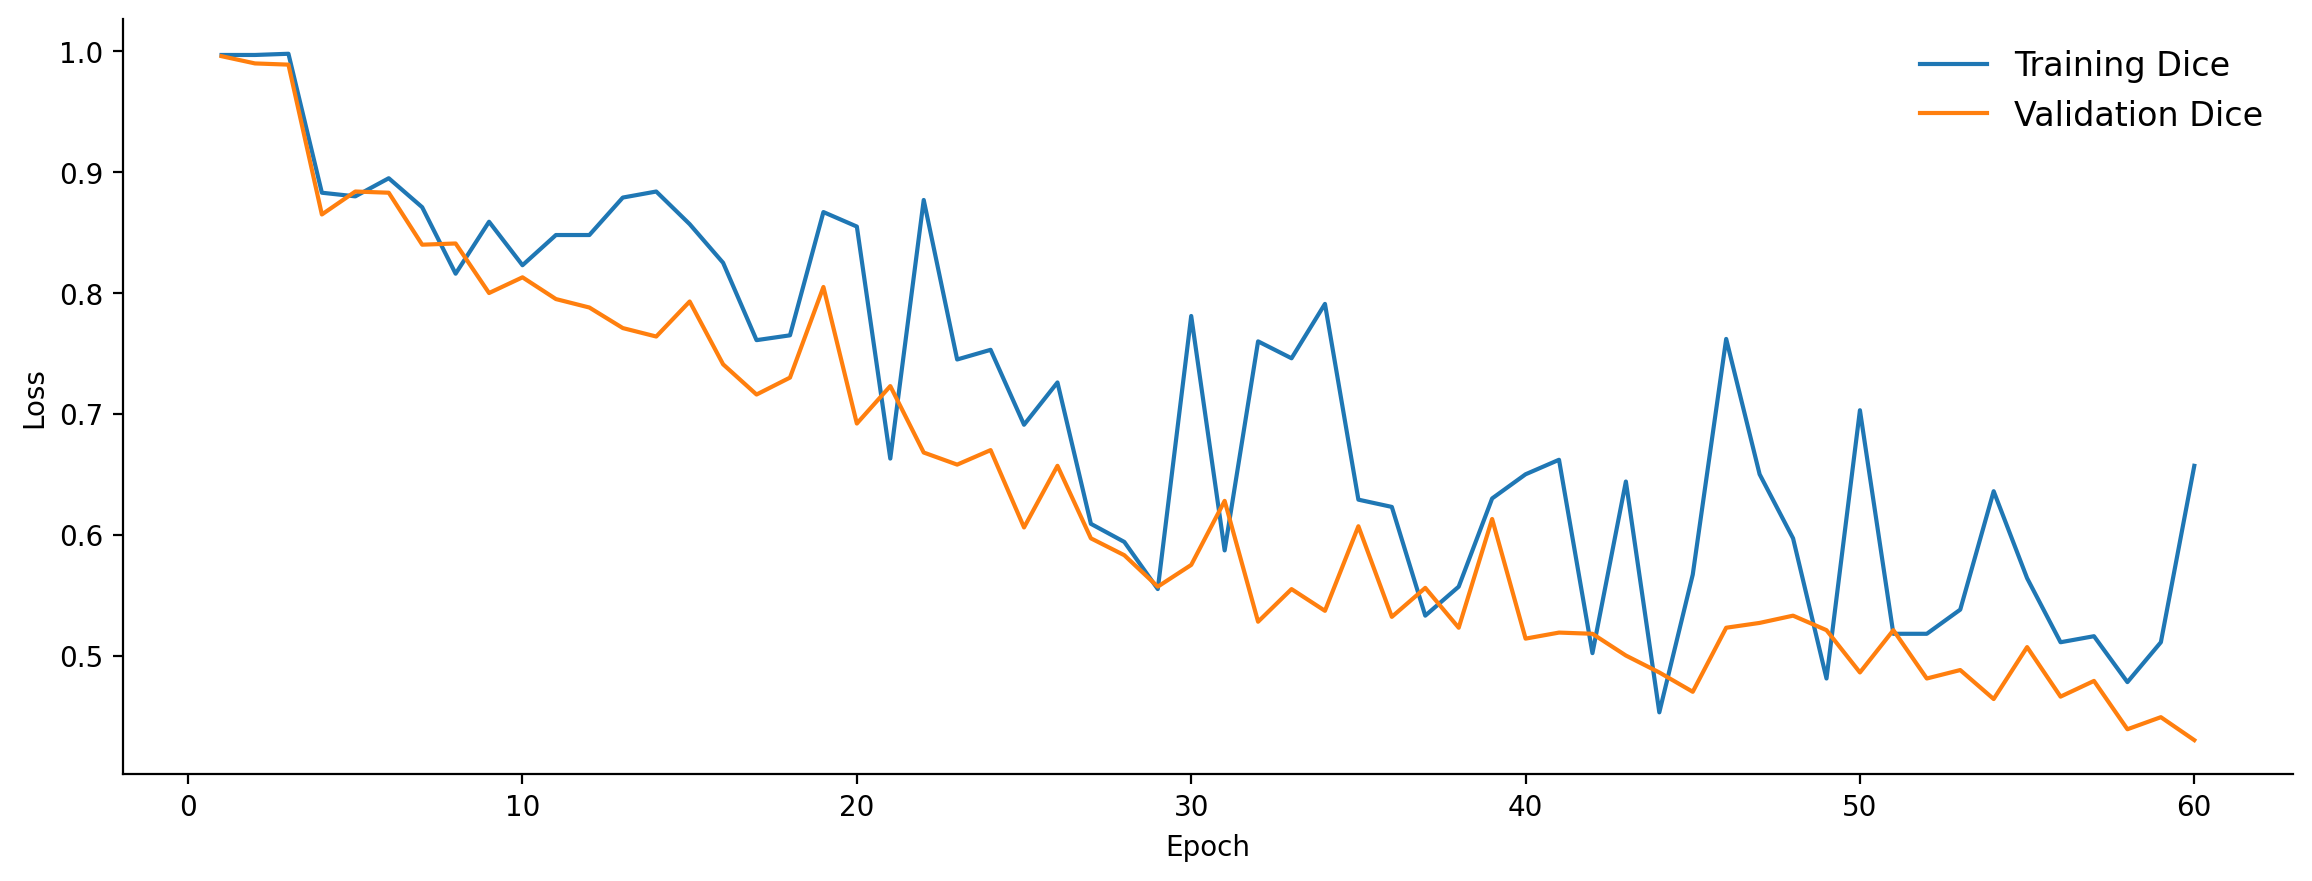

In [ ]:
fig , axes = plt.subplots(1, 1, figsize=(14, 5))
axes.plot(table['epoch'], table['train dice'], label = 'Training Dice')
axes.plot(table['epoch'], table['valid dice'], label = 'Validation Dice')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

In [ ]:
torch.manual_seed(3)
(t2, mask)= next(iter(train_loader)) #get one batch
t2 = t2.to(device); mask = mask.to(device, dtype = torch.float)
reconstructions = unet(t2)

In [ ]:
def show_subplot(t2, mask, maskh):
    plt.rcParams.update({'font.size': 7})
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 3, 1); plt.title("T2"); plt.axis("off")
    plt.imshow(t2)
    
    plt.subplot(1, 3, 2); plt.title("Mask"); plt.axis("off")
    plt.imshow(mask)

    plt.subplot(1, 3, 3); plt.title("Predicted mask"); plt.axis("off")
    plt.imshow(maskh, vmin = torch.min(mask), vmax = torch.max(mask))

    plt.show()

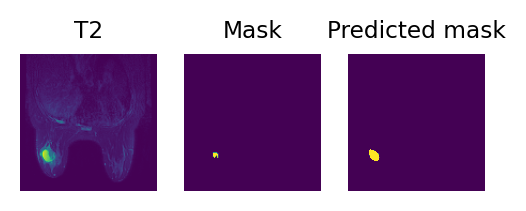

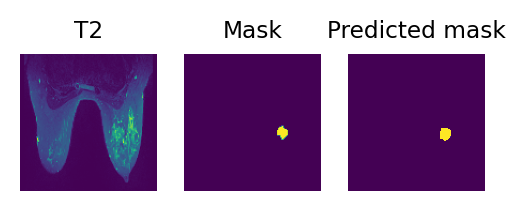

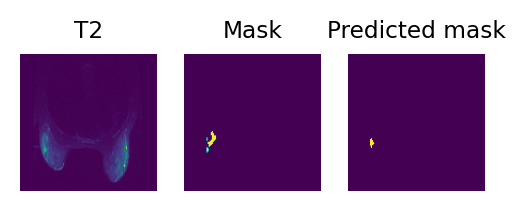

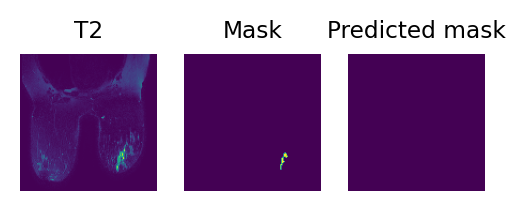

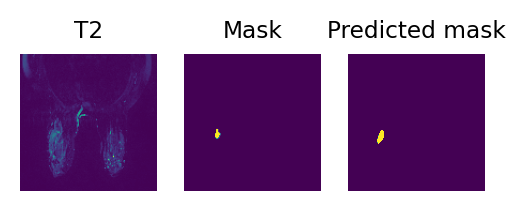

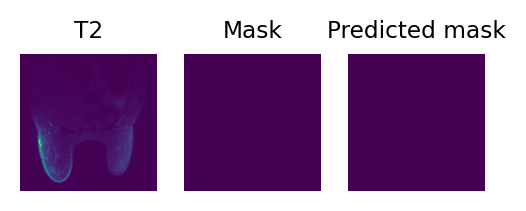

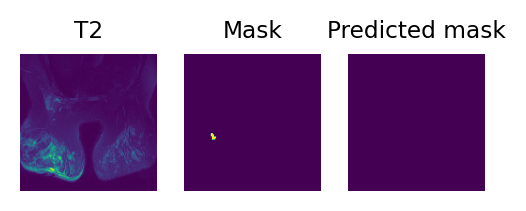

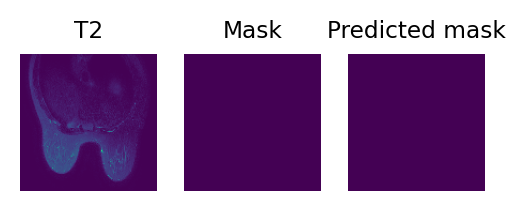

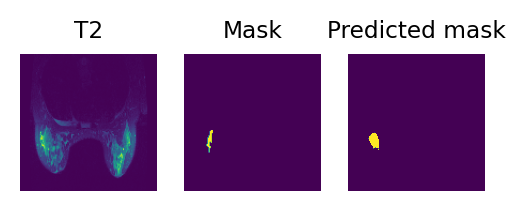

In [ ]:
#BCE and dice, on augmented data. Not same images as ori, since dataset has changed!
idx = [1,4,8,9,15, 17, 25, 27, 28]

t2s = [t2[id][0] for id in idx]
masks = [mask[id][0] for id in idx]

maskhs = [reconstructions[id][0] for id in idx]

for i in range(len(idx)):
  show_subplot(t2s[i].cpu(), masks[i].cpu(), maskhs[i].cpu().detach())